# Seminar Applied Predictive Analytics  - Topic 2. Interpretability

Group Members:
*   Ali, Jaabous
*   Christian, Bernard
*  Mahsa, Mobaleghnasseri
* Lea, Paoli

Submitted on July 22, 2022. 





# Table of Contents

<details>
<summary>Show Table of Contents </summary>
<br>

1. [Import Python Packages](#Python_Packages)
2. [Introduction](#Introduction)
3. [Literature Review](#Literature_Review)

    3.1 [The Importance of Interpretability](#The_Importance_of_Interpretability)

    3.2 [Dimensions of Interpretability](#Dimensions_of_Interpretability)

    3.3 [A Definition of Interpretability](#Definition_of_Interpretability)

    3.4 [Methods to Achieve Interpretability](#Methods_Interpretability)

    3.5 [Literature Table](#LitTab)
4. [Research Question](#ResearchQuestion)
5. [Hypotheses Development](#Hypotheses)
6. [Data](#Data)

    6.2 [Load Data](#LoadData)

    6.3 [Summary Statistics of Numerical Features](#summary_num)

    6.4 [Summary Statistics of Categorical Features](#summary_cat)

7. [Methodology](#Methodology)

    7.1 [Logistic Regression](#logit)

    7.2 [XGBoost](#XGB)

    7.3 [Local, Model-Agnostic Post-Hoc Methods](#LMAPH)

8. [Data Handling and Preprocessing](#Preprocessing)

    8.1 [Dealing with Missings](#Missing)

    8.2 [Adapting Data Formats](#Formatting)

    8.3 [Handling Category Mismatches](#Mismatches)

    8.4 [Dummy Encoding](#Dummies)

    8.5 [Summary](#Summary1)

    8.6 [Dataset Split and Scaling](#Split)

9. [Results](#Results)

    10.1 [Stage II](#StageII)

    10.2 [Stage III](#StageIII)

    10.3 [Summary](#Summary2)

11. [A Case for Cost-Sensitive Learning](#CostAnalysis)
12. [Limitations and Future Research](#Limitations)
13. [References](#References)
14. [Appendix](#Appendix)

</details>

# Import Python Packages <a name="Python_Packages"></a>

In [ ]:
# install required packages 
!pip install lime --quiet
!pip install alibi --quiet
!pip install shap --quiet
!pip install lime-stability --quiet
!pip install xgboost --quiet
!pip install --upgrade xgboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
# required packages
# at the beginning we make sure to consider all necessary packages

## Standard packages
import pandas as pd
import numpy as np
import sklearn
import os
import matplotlib.pyplot as plt
import time

## Feature Engineering
import datetime  # Transform date features
import seaborn as sns # corelation matrix
from sklearn.preprocessing import StandardScaler # Scaling Data

## Used Models
### Logit
from sklearn.linear_model import LogisticRegression
### xgboost
import xgboost as xgb

## Validation of model
from sklearn import metrics
from sklearn.metrics import accuracy_score, f1_score,confusion_matrix
from sklearn.model_selection import train_test_split

## Interpretability methods
### SHAP
import shap
### LIME
import lime
from lime.lime_tabular import LimeTabularExplainer
from lime_stability.stability import LimeTabularExplainerOvr
from lime_stability.utils import LocalModelError
### ANCHORS
from alibi.explainers import AnchorTabular

# Introduction <a name="Introduction"></a>

The widespread use of computational algorithms in various industries in the recent decade confirms a transformation of business processes towards a more computation-driven approach (Visani et al. 2022). Simple methods, the most famous being Linear Regression and Generalized Linear Models (William H. Greene 2003), have been followed by the advent of powerful computing tools, leading to the development of more sophisticated machine learning techniques. In particular, machine learning models can perform intelligent tasks usually done by humans. In combination with the huge availability of data sources and increased computational power, machine learning techniques have reduced the time to achieve more accurate results. Despite these advantages, machine learning models display weaknesses especially when it comes to interpretability, i.e., “the ability to explain or to present the results, in understandable terms, to a human” (Hall and Gill 2019). This issue is mainly caused by large model structures and huge numbers of iterations involved in machine learning algorithms combined with potentially many mathematical calculations, hiding the logic underlying these models and making them hard to grasp for humans. Consequently, a substantial amount of techniques have been proposed in the recent literature to make these models with an increased complexity more understandable for humans (Visani et al. 2022). Considering the importance of interpretability with a local focus i.e. trying to explain a single prediction, this paper investigates various aspects of interpretability and the challenges involved in implementing the corresponding methods within the credit risk industry. In particular, three different techniques are employed: LIME (Local Interpretable Model Agnostic Explanations), SHAP (Shapley Additive exPlanations), and the less common approach Anchor.

# Literature Review <a name="Literature_Review"></a>

## The Importance of Interpretability <a name="The_Importance_of_Interpretability"></a>

### Legal Considerations

Article 8 of the European Union’s (EU) Charter of Fundamental Rights of the European Union stipulates the right of "Protection of personal data" (European Union 2012). Building on this fundamental right, the EU passed Regulation (EU) 2016/679, better known as General Data Protection Regulation (GDPR), in 2016. The regulation, which has been legally binding since 2018, aims to "strengthen individuals' fundamental rights in the digital age”. At the same time, according to the regulation, model performance should not be the sole criterion for the suitability of a machine learning. (European Commission 2022) Recital 71 expands on this point and specifically states that the "data subject [author's note: respective individual] should have the right not to be subject to a decision, which may include a measure, evaluating personal aspects relating to him or her which is based solely on automated processing and which produces legal effects concerning him or her or similarly significantly affects him or her, such as automatic refusal of an online credit application or e-recruiting practices without any human intervention. [...] In any case, such processing should be subject to suitable safeguards, which should include specific information to the data subject and the right to obtain human intervention, to express his or her point of view, to obtain an explanation of the decision reached after such assessment and to challenge the decision." (European Parliament and the Council 2016) Article 22 manifests the right to "not to be subject to a decision based solely on automated processing [...] [and] at least the right to obtain human intervention on the part of the controller, to express his or her point of view and to contest the decision." (European Parliament and the Council 2016) In addition, article 14 requires that the individual is provided with "meaningful information about the logic involved, as well as the significance" in order to "ensure fair and transparent processing" of personal data. (European Parliament and the Council 2016) This contradicts the approach of many common supervised machine learning algorithms, which rely purely on statistical associations rather than causalities or explanatory rules to produce out-of-sample predictions (Goodman and Flaxman 2017). 

Similarly, the Consumer Financial Protection Bureau (2022) clarified that the rights set out in the Equal Credit Opportunity Act (Regulation B) also apply to decisions based on “complex algorithms”. The Equal Credit Opportunity Act (Regulation B) prohibits adverse actions such as the denial of a credit application on the basis of discriminatory behavior and grants credit applicants against which an adverse action has been taken the right to obtain a statement rationalizing this adverse decision.(Bureau of Consumer Financial Protection 2011) The Consumer Financial Protection Bureau (2022) unequivocally formulates that the law does "not permit creditors to use complex algorithms when doing so means they cannot provide the specific and accurate reasons for adverse actions.” (Consumer Financial Protection Bureau 2022) The development of interpretable algorithms is therefore not only desirable but a legal necessity. 

### Interpretability in Credit Risk

It is evident that a bank's objective is to maximize its franchise value. The minimization of its credit risk plays a key role in this regard. The bank will hence try to reduce credit default as far as possible by screening credit applicants. Banks therefore benefit from models that predict the probability of default for a credit applicant based on observable factors. For this reason, machine learning approaches are in principle also highly interesting for banks. At the same time, model performance is not the sole criterion for the suitability of a machine learning algorithm for the use in the banking sector since the bank must also satisfy its stakeholders. The most important stakeholders in this context are a) the bank's credit applicants and b) the supervisory authority that regulates banks. 

<img src="https://raw.githubusercontent.com/Group2Interpretability/APA_Interpretability/21d1c95359fc57fbb1a390423ed08739bfc9c36f/Pictures/Picture2.png" width="500" height="500" />

*Image 1:  A Bank's Primary Stakeholders; own illustration.*






The considerations on the customer side have already been addressed in the section on legal implications: Credit applicants have a right to know the reasons why their credit application was (not) granted. At the same time, the topic is currently gaining relevance from a regulatory standpoint: For example, the Deutsche Bundesbank and BaFin (2021), the two central supervisory authorities of German banks, warned in a consultation paper of increased model risk due to the black-box nature of many machine learning techniques and called for a focus on interpretability. (Deutsche Bundesbank and BaFin 2021) Responses to the consultation paper indicated that respondents in the banking and insurance industry believe that the main benefit of interpretable models is to facilitate model selection by allowing the validity of the model to be verified by a human with domain knowledge. At the same time, the consultation highlights that the implementation of interpretable models is considered cost-intensive and therefore only worthwhile undertaking if the effort is counterbalanced by a significant increase in performance. (Deutsche Bundesbank and BaFin 2022)

## Dimensions of Interpretability <a name="Dimensions_of_Interpretability"></a>

Lipton (2016) clarifies that no universal definition of the term "interpretability" exists. Rather, machine learners seek different underlying goals when searching for interpretable algorithms. His taxonomy identifies five dimensions users wish to achieve through the application of interpretable models (see Figure 2): 


1.   Trust
2.   Causality
3.  Transferability
4. Informativeness
5. Fairness

Trust is partially covered by model performance: The higher a model’s predictive accuracy the less false predictions it makes and the more a user can rely on the model’s predictions. However, there is more to trust then just accuracy. First, there is a psychological component: Humans may tend to have more faith in a model they are able to grasp intellectually. Second, an algorithm may be perceived as more trustworthy if it makes wrong judgement in cases in which a human decision maker would have misjudged as well as in such cases human intervention would have failed to yield an improvement. (Lipton 2016) The more severe the consequences of a model decision, the more important trust becomes. (Ribeiro et al. 2016)

Another component of interpretability is the ability to establish causal relationships between the features and the target. In standard supervised learning techniques this is problematic. Thus, inducing causal relationships in a machine learning context is a research branch in its own right. 

In addition, one would ideally want to train a machine learning model that can be applied to new data without significant performance loss. Data scientists usually try to achieve this by partitioning a given dataset into a test and training dataset. Within this context, a model is thus deemed transferable if it is able to predict the test data given what it has learned about the data’s underlying structure though studying the training dataset. In contrast to this rather narrow definition of transferability, a human decision maker typically performs better at generalizing previously obtained knowledge and applying it to entirely new context. (Lipton 2016) Here, a similar reasoning can be applied as in the case of the dimension "Trust": A model appears interpretable to humans if it is evident how the model applies known principles to new situations and if it fails to do so in scenarios in which a human would fall short as well. 

The fourth dimension is the desire for a model to be as informative as possible to benefit decision makers to the maximum degree possible. 

Lastly, ethical considerations constitute grounds for the use of interpretable models. Users wish to ensure that model-based decisions are made in a manner that the user, supervisor or society deems ethical. (Lipton 2016) 

<img src="https://raw.githubusercontent.com/Group2Interpretability/APA_Interpretability/21d1c95359fc57fbb1a390423ed08739bfc9c36f/Pictures/Picture1.png" width="750" height="500" />

*Image 2:  The Five Dimensions of Interpretability; own illustration based on Lipton (2016).*




## A Definition of Interpretability <a name="Definition_of_Interpretability"></a>

Given the research question of this paper, the question arises which dimensions of Lipton’s (2016) interpretability taxonomy are of particular relevance in the area of credit risk and how the term should be defined in our given context. Considering the main stakeholders of a bank, we find the dimensions “Trust” and “Informativeness” to be of particular relevance. Trust in the credit risk context is strongly related to credit risk reduction but goes beyond it. In addition to good predictive power (and thus low credit default probability), there must also be a sense of security among stakeholders that the model is drawing its predictions on the basis of meaningful conclusions. In addition, models must be as informative as possible in order to plausibly communicate decisions to stakeholders. To illustrate this point, imagine a situation in which a credit applicant has been classified as not creditworthy on the basis of a machine learning algorithm. Naturally, the credit applicant will expect a plausible explanation for this. An interpretable machine learning technique should provide credit officers, who have to advocate model decisions in front of credit applicants, with all the necessary information. Our definition of "interpretability" is thus strongly geared to the needs of the end user. For the purposes of this paper, we thus adopt the definition of “interpretability” by  Ribeiro et al. (2016) who classify an explanation as interpretable if it generates a “qualitative understanding [of the relationship] between the input variables and the response”. They aim at a model that can support human decision makers by making predictions and providing rationales for them. The human, who acts as the final authority in the decision-making process, then evaluates the model's predictions and justifications, and uses his or her domain knowledge to decide whether the decision is conclusive. (Ribeiro et al. 2016)

## Methods to Achieve Interpretability <a name="Methods_Interpretability"></a>

Having outlined the importance of interpretable machine learning models in general and in particular in credit risk, one must ask in which way interpretability can be achieved. Figure 3 gives a high-level overview. Most fundamentally, machine learning models can be divided into intrinsically interpretable models (so-called white-box-models) and black-box-models. 

Intrinsically interpretable models are – as the name suggests - in themselves interpretable and thus do not require further adjustments to deliver interpretable explanations. For a model to be intrinsically explainable, it therefore needs to be sufficiently simple for a human to be able to grasp it. For example, linear regression, logistic regression and a shallow decision tree can be considered intrinsically explainable models. 

A model that is not inherently explainable requires co-called post-hoc methods to render its results explainable ex-post.  These post-hoc methods fall into one of two categories: They are either model-specific or model-agnostic. As the name suggests, model-specific interpretable machine learning algorithms are tailored towards specific model classes. Model-agnostic methods, on the other hand, are suited for any class of model. A further distinction can be made with regard to the scope of the interpretation offered by the post-hoc method: Does the explanation cover the entirety of the model’s decision behavior and can thus explain according to which principles the models arrive at its conclusions? Or does the explanation offered concern a single observation and can thus explain the conclusions drawn by the models for any particular case? The latter of these options is called “local interpretability” while the former is referred to as “global interpretability”. (Molnar 2022)

<img src="https://raw.githubusercontent.com/Group2Interpretability/APA_Interpretability/21d1c95359fc57fbb1a390423ed08739bfc9c36f/Pictures/Picture3_mod.png" width="750" height="600" />

*Image 3: Overview of Interpretability Methods; own illustration.*



## Literature Table <a name="LitTab"></a>


In [ ]:
# Add Literature Table
file_name = 'https://raw.githubusercontent.com/Group2Interpretability/\
APA_Interpretability/main/Input/LiteratureTable.csv'
Literature_Table = pd.read_csv(file_name,index_col=False, sep=";")
pd.set_option('display.max_colwidth', None)

dfStyler = Literature_Table.style.set_properties(**{'text-align': 'left'})\
.hide_index()
display(dfStyler.set_table_styles([dict(selector='th', 
                                        props=[('text-align', 'left')])]))
print("-----------------------------------------------------------------------")
print("Table 1: Literature Overview, Interpretability Methods.")

-----------------------------------------------------------------------
Table 1: Literature Overview, Interpretability Methods.


# Research Question <a name="ResearchQuestion"></a>

This paper aims to answer the question whether it is possible to develop a model framework applicable within credit risk that achieves a high predictive performance as measured by the AUC whilst maintaining or even improving interpretability. A related question hence is whether there is a trade-off between performance (AUC) and interpretability. 

# Hypotheses Development <a name="Hypotheses"></a>

Previous literature has highlighted the trade-off between simple, intrinsically interpretable models with limited accuracy and less transparent black-box models which exhibit a high predictive power. (Bussmann et al. 2021; Emad Azhar Ali et al. 2021) We expect that such a trade-off between interpretability and performance is also visible using our dataset when comparing a white-box model to a black-box model, as verbalized by hypotheses I and II. 


I)	The black-box model outperforms the white-box model (measured by the AUC).


II)	The white-box model is better explainable than the black-box model.


We suspect that the trade-off formulated in hypotheses I and II can be relaxed by employing post-hoc methods, leading us to hypothesis III:


III)	Through the usage of post-hoc methods, it is possible to achieve a higher performance compared to a white-box model (measured by the AUC) and having a higher degree of interpretability (compared to the black-box model) at the same time. 

# Data <a name="Data"></a>

The analysis is performed using a credit risk dataset obtained from Freddie Mac (2021). Freddie Mac is a U.S. mortgage bank that was created by the United States Congress in 1970 to “ensure a reliable and affordable supply of mortgage funds throughout the country”. (Federal Housing Finance Agency 2022) Instead of lending to individuals directly, its business consists of purchasing loans on the secondary housing market, bundling them and selling them in the form of Mortgage-Backed Securities (MBS).(Freddie Mac 2022a) It separates its business operations into three major divisions: Single-Family Division, Multifamily Division and Capital Markets Division. The dataset used in this paper is the so-called Single Family Loan-Level Dataset (Origination Data File). As the name suggests it covers loans purchased by Freddie Mac’s Single-Family Division. (Freddie Mac 2021)

 The dataset includes loans originated between 1999 and the Origination Cutoff Date.(Freddie Mac 2022c) The loans chosen for inclusion were selected at random from Freddie Mac’s loan portfolio and every loan had the same probability of inclusion. (Freddie Mac 2022b) Approximately 150.000 observations with the first payment date from 2013 to 2016 are used as training data to build the prediction models, while the test data consists of approximately 50.000 observations from 2017 to 2019.

In total, the dataset includes 31 features. These are described in the following table.

In [ ]:
# Table of Features 
file_name = 'https://raw.githubusercontent.com/Group2Interpretability/\
APA_Interpretability/main/Input/columns_formatted.csv'
Feature_Table = pd.read_csv(file_name,index_col=False)
pd.set_option('display.max_colwidth', None)
Feature_Table = Feature_Table.drop('#', axis=1)
dfStyler = Feature_Table.style.set_properties(**{'text-align': 'left'})\
.hide_index()
display(dfStyler.set_table_styles([dict(selector='th', 
                                        props=[('text-align', 'left')])]))
print("-----------------------------------------------------------------------")
print("Table 2: Feature Description, taken from Freddie Mac (2022c)")

-----------------------------------------------------------------------
Table 2: Feature Description, taken from Freddie Mac (2022c)


The target feature, i.e. whether a loan defaulted or not defaulted, are not given in the original dataset. In constructing target values for the training dataset, the definition of default of the Basel Committee on Banking Supervision (2004) was used: 


“A default is considered to have occurred with regard to a particular obligor when […] [t]he obligor is past due more than 90 days on any material credit obligation to the banking group.[…] Overdrafts will be considered as being past due once the customer has breached an advised limit or been advised of a limit smaller than current outstandings.“ 


Using this definition, the overall default ratio (defaulted loans over non defaulted loans) is given by 0.009103, i.e. approximately 0.9%. In the following, summary statistics are presented for numerical features. In addition to mean and standard deviation, the mean difference (mean of non-defaulted loans – mean of defaulted loans) is calculated. Features, for which the mean difference is negative (positive), are highlighted in red (green). 


Categorical features, on the other hand, are treated one-by-one. For each category of a feature, the absolute and relative frequency in the test and training dataset is indicated. Then, for the training dataset, the proportion of defaulted and non-defaulted loans within each category is reported (for the test dataset, this is not possible, as no target values are available). Finally, the ratio of defaulted and non-defaulted loans within each category is calculated and the differences to the overall default ratio are calculated. Negative differences are highlighted in green, positive differences in red. In this way, the reader is given a quick overview of the data and can identify potential correlations between feature characteristics and the target. 


As an example, consider the feature ‘servicer_name’. Here, for ‘servicer_name == SPECIALIZED LOAN SERVICING LLC’, the default ratio is equal to approximately 15.2% and thus 16.7 times higher than the average default ratio. This is on example of an interesting prima facie evidence that becomes visible through this preliminary analysis. 


For further information regarding the data collection and the characteristics of the dataset, the interested reader is referred to the data provider Freddie Mac (2021). 

## Load Data <a name="LoadData"></a>

In [ ]:
# import train data
file_train = 'https://raw.githubusercontent.com/Group2Interpretability/\
APA_Interpretability/main/Input/data_train.csv'
df_train = pd.read_csv(file_train,index_col=False)
# import test data
file_test = 'https://raw.githubusercontent.com/Group2Interpretability/\
APA_Interpretability/main/Input/data_test.csv'
df_test = pd.read_csv(file_test,index_col=False)

Columns (27) have mixed types.Specify dtype option on import or set low_memory=False.


In [ ]:
# Overall Ratio Defaults/Non-Defaults as Benchmark for further analysis
# Calculate overall ratio defaults/non-defaults as benchmark
ratio_overall = df_train.groupby(by=["TARGET"])["TARGET"].count()[1]\
                  /df_train.groupby(by=["TARGET"])["TARGET"].count()[0]
print("Overall ratio of defaults/non-defaults: %0.6f" %ratio_overall)

Overall ratio of defaults/non-defaults: 0.009103


## Summary Statistics of Numerical Features <a name="summary_num"></a>

In [ ]:
# Define all numerical features
numerical_cols = ['fico', 'mi_pct', 'cnt_units', 'cltv', 'dti', 'orig_upb', 
                  'ltv', 'int_rt', 'orig_loan_term', 'cnt_borr']
# Calculate mean grouped by the target feature
df_diff = df_train.groupby(["TARGET"])[numerical_cols].mean()
df_diff=pd.concat((df_diff,df_diff.diff(periods=len(df_diff)-1).dropna()))
df_diff = df_diff.reset_index(drop = True)
df_diff.index = ('Mean_Non_Default', 'Mean_Default', 'Difference_in_Mean')
# Calculate std grouped by the target feature
df_std = df_train.groupby(["TARGET"])[numerical_cols].std()
df_std.index = ('Std_Non_Default', 'Std_Default')
# Calculate the differences in mean and std of defaulting and non-defaulting
df_diff = pd.concat([df_diff, df_std] )
df_diff = df_diff.reindex(['Mean_Non_Default', 'Std_Non_Default', 
                           'Mean_Default', 'Std_Default', 'Difference_in_Mean'])
# Color the results depending on output
# Subset dataframe with condition to color the different results
test = df_diff[df_diff.index=='Difference_in_Mean']
# Pass the subset dataframe index and column to pd.IndexSlice
slice_ = pd.IndexSlice[test.index, test.columns]

# Color the results
df_diff.style.applymap(lambda v: 'color:green;' if (v > 0) else None, 
                       subset = slice_)\
              .applymap(lambda v: 'color:red;' if (v <= 0) else None, 
                        subset = slice_)\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('fico'): "{:.2f}",
                           ('mi_pct'): "{:.2f}",
                           ('cnt_units'): "{:.2f}",
                           ('cltv'): "{:.2f}",
                           ('ltv'): "{:.2f}",
                           ('int_rt'): "{:.2f}",
                           ('orig_loan_term'): "{:.2f}",
                           ('cnt_borr'): "{:.2f}"
                          })

## Summary Statistics of Categorical Features <a name="summary_cat"></a>

In [ ]:
# cd_msa
# create table from train data
df_vis_train = df_train.groupby("cd_msa")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['cd_msa']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
 # calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                     - ratio_overall
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'], 
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault', 
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['cd_msa']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_cd_msa = pd.merge(df_join1,df_join2 ,on='cd_msa',how='outer')
df_cd_msa = df_cd_msa.set_index("cd_msa")
df_cd_msa = df_cd_msa[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 
                       'Ratio_Cat_Test', 'Ratio_NonDefault', 'Ratio_Default', 
                       'Ratio_default/nondefault', 'Difference_Overall']]

# do some color changing
subset = ['Difference_Overall']
df_cd_msa.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                         subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# cnt_borr
# create table from train data
df_vis_train = df_train.groupby("cnt_borr")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['cnt_borr']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                             - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'], 
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault', 
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['cnt_borr']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_cnt_borr = pd.merge(df_join1,df_join2 ,on='cnt_borr',how='outer')
df_cnt_borr = df_cnt_borr.set_index("cnt_borr")
df_cnt_borr = df_cnt_borr[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 
                           'Ratio_Cat_Test', 'Ratio_NonDefault', 
                           'Ratio_Default', 'Ratio_default/nondefault', 
                           'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_cnt_borr.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                           subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# flag_fthb
# create table from train data
df_vis_train = df_train.groupby("flag_fthb")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['flag_fthb']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                           - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'], 
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault', 
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['flag_fthb']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_flag_fthb = pd.merge(df_join1,df_join2 ,on='flag_fthb',how='outer')
df_flag_fthb = df_flag_fthb.set_index("flag_fthb")
df_flag_fthb = df_flag_fthb[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 
                             'Ratio_Cat_Test', 'Ratio_NonDefault', 
                             'Ratio_Default', 'Ratio_default/nondefault', 
                             'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_flag_fthb.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                            subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# flag_sc
# create table from train data
df_vis_train = df_train.groupby("flag_sc")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['flag_sc']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['flag_sc']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_flag_sc = pd.merge(df_join1,df_join2 ,on='flag_sc',how='outer')
df_flag_sc = df_flag_sc.set_index("flag_sc")
df_flag_sc = df_flag_sc[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 
                         'Ratio_Cat_Test', 'Ratio_NonDefault', 'Ratio_Default', 
                         'Ratio_default/nondefault', 'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_flag_sc.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                          subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# int_only_ind
# create table from train data
df_vis_train = df_train.groupby("int_only_ind")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['int_only_ind']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['int_only_ind']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_int_only_ind = pd.merge(df_join1,df_join2 ,on='int_only_ind',how='outer')
df_int_only_ind = df_int_only_ind.set_index("int_only_ind")
df_int_only_ind = df_int_only_ind[['Count_Train', 'Ratio_Cat_Train', 
                                   'Count_Test', 'Ratio_Cat_Test', 
                                   'Ratio_NonDefault', 'Ratio_Default', 
                                   'Ratio_default/nondefault', 
                                   'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_int_only_ind.style.applymap(lambda v: 'color:red;' if (v > 0) else None,
                               subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None,
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# loan_purpose
# create table from train data
df_vis_train = df_train.groupby("loan_purpose")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['loan_purpose']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault', 
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['loan_purpose']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_loan_purpose = pd.merge(df_join1,df_join2 ,on='loan_purpose',how='outer')
df_loan_purpose = df_loan_purpose.set_index("loan_purpose")
df_loan_purpose = df_loan_purpose[['Count_Train', 'Ratio_Cat_Train', 
                                   'Count_Test', 'Ratio_Cat_Test', 
                                   'Ratio_NonDefault', 'Ratio_Default', 
                                   'Ratio_default/nondefault', 
                                   'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_loan_purpose.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                               subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# occpy_sts
# create table from train data
df_vis_train = df_train.groupby("occpy_sts")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['occpy_sts']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault', 
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['occpy_sts']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_occpy_sts = pd.merge(df_join1,df_join2 ,on='occpy_sts',how='outer')
df_occpy_sts = df_occpy_sts.set_index("occpy_sts")
df_occpy_sts = df_occpy_sts[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 
                             'Ratio_Cat_Test', 'Ratio_NonDefault', 
                             'Ratio_Default', 'Ratio_default/nondefault', 
                             'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_occpy_sts.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                            subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# pgrm_ind
# create table from train data
df_vis_train = df_train.groupby("pgrm_ind")["TARGET"]\
                                .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['pgrm_ind']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['pgrm_ind']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_pgrm_ind = pd.merge(df_join1,df_join2 ,on='pgrm_ind',how='outer')
df_pgrm_ind = df_pgrm_ind.set_index("pgrm_ind")
df_pgrm_ind = df_pgrm_ind[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 
                           'Ratio_Cat_Test', 'Ratio_NonDefault', 
                           'Ratio_Default', 'Ratio_default/nondefault', 
                           'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_pgrm_ind.style.applymap(lambda v: 'color:red;' if (v > 0) else None,
                           subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None,
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# ppmt_pnlty
# create table from train data
df_vis_train = df_train.groupby("ppmt_pnlty")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['ppmt_pnlty']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['ppmt_pnlty']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_ppmt_pnlty = pd.merge(df_join1,df_join2 ,on='ppmt_pnlty',how='outer')
df_ppmt_pnlty = df_ppmt_pnlty.set_index("ppmt_pnlty")
df_ppmt_pnlty = df_ppmt_pnlty[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 
                               'Ratio_Cat_Test', 'Ratio_NonDefault', 
                               'Ratio_Default', 'Ratio_default/nondefault', 
                               'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_ppmt_pnlty.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                             subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# prod_type
# create table from train data
df_vis_train = df_train.groupby("prod_type")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['prod_type']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['prod_type']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_prod_type = pd.merge(df_join1,df_join2 ,on='prod_type',how='outer')
df_prod_type = df_prod_type.set_index("prod_type")
df_prod_type = df_prod_type[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 
                             'Ratio_Cat_Test', 'Ratio_NonDefault', 
                             'Ratio_Default', 'Ratio_default/nondefault', 
                             'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_prod_type.style.applymap(lambda v: 'color:red;' if (v > 0) else None,
                            subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None,
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# prop_type
# create table from train data
df_vis_train = df_train.groupby("prop_type")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['prop_type']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['prop_type']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_prop_type = pd.merge(df_join1,df_join2 ,on='prop_type',how='outer')
df_prop_type = df_prop_type.set_index("prop_type")
df_prop_type = df_prop_type[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 
                             'Ratio_Cat_Test', 'Ratio_NonDefault', 
                             'Ratio_Default', 'Ratio_default/nondefault', 
                             'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_prop_type.style.applymap(lambda v: 'color:red;' if (v > 0) else None,
                            subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None,
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# prop_val_meth
# create table from train data
df_vis_train = df_train.groupby("prop_val_meth")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['prop_val_meth']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['prop_val_meth']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_prop_val_meth = pd.merge(df_join1,df_join2 ,on='prop_val_meth',how='outer')
df_prop_val_meth = df_prop_val_meth.set_index("prop_val_meth")
df_prop_val_meth = df_prop_val_meth[['Count_Train', 'Ratio_Cat_Train', 
                                     'Count_Test', 'Ratio_Cat_Test', 
                                     'Ratio_NonDefault', 'Ratio_Default', 
                                     'Ratio_default/nondefault', 
                                     'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_prop_val_meth.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                                subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# rel_ref_ind
# create table from train data
df_vis_train = df_train.groupby("rel_ref_ind")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['rel_ref_ind']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['rel_ref_ind']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_rel_ref_ind = pd.merge(df_join1,df_join2 ,on='rel_ref_ind',how='outer')
df_rel_ref_ind = df_rel_ref_ind.set_index("rel_ref_ind")
df_rel_ref_ind = df_rel_ref_ind[['Count_Train', 'Ratio_Cat_Train', 'Count_Test',
                                 'Ratio_Cat_Test', 'Ratio_NonDefault', 
                                 'Ratio_Default', 'Ratio_default/nondefault', 
                                 'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_rel_ref_ind.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                              subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# seller_name
# create table from train data
df_vis_train = df_train.groupby("seller_name")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['seller_name']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['seller_name']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_seller_name = pd.merge(df_join1,df_join2 ,on='seller_name',how='outer')
df_seller_name = df_seller_name.set_index("seller_name")
df_seller_name = df_seller_name[['Count_Train', 'Ratio_Cat_Train', 'Count_Test',
                                 'Ratio_Cat_Test', 'Ratio_NonDefault', 
                                 'Ratio_Default', 'Ratio_default/nondefault', 
                                 'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_seller_name.style.applymap(lambda v: 'color:red;' if (v > 0) else None,
                              subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None,
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# servicer_name
# create table from train data
df_vis_train = df_train.groupby("servicer_name")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['servicer_name']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'],
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['servicer_name']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_servicer_name = pd.merge(df_join1,df_join2 ,on='servicer_name',how='outer')
df_servicer_name = df_servicer_name.set_index("servicer_name")
df_servicer_name = df_servicer_name[['Count_Train', 'Ratio_Cat_Train', 
                                     'Count_Test', 'Ratio_Cat_Test', 
                                     'Ratio_NonDefault', 'Ratio_Default', 
                                     'Ratio_default/nondefault', 
                                     'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_servicer_name.style.applymap(lambda v: 'color:red;' if (v > 0) else None,
                                subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None,
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# st
# create table from train data
df_vis_train = df_train.groupby("st")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['st']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'], 
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault',
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['st']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_st = pd.merge(df_join1,df_join2 ,on='st',how='outer')
df_st = df_st.set_index("st")
df_st = df_st[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 'Ratio_Cat_Test',
               'Ratio_NonDefault', 'Ratio_Default', 
               'Ratio_default/nondefault', 'Difference_Overall']]
# do some color changing
subset = ['Difference_Overall']
df_st.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                     subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

In [ ]:
# zipcode
# create table from train data
df_vis_train = df_train.groupby("zipcode")["TARGET"]\
                       .value_counts(normalize=True).unstack()
df_vis_train = df_vis_train.fillna(0)
df_vis_train["Count_Train"] = df_train.groupby(['zipcode']).size()
df_vis_train['Ratio_Cat_Train'] = df_vis_train.Count_Train / df_train.shape[0]
df_vis_train["Ratio_default/nondefault"] = df_vis_train[1]/df_vis_train[0]
# calculate difference to overall ratio
df_vis_train["Difference_Overall"] = df_vis_train["Ratio_default/nondefault"] \
                                                 - ratio_overall 
df_vis_train = df_vis_train.sort_values(by=['Ratio_default/nondefault'], 
                                        ascending=False)
df_vis_train = df_vis_train.rename(columns={0: 'Ratio_NonDefault', 
                                            1: 'Ratio_Default'})
# create table from test data
# calculate number of observation in each category
Count = df_test.groupby(['zipcode']).size() 
df_vis_test = pd.DataFrame(data = Count,  columns=['Count_Test'])
df_vis_test['Ratio_Cat_Test'] = df_vis_test.Count_Test / df_train.shape[0]
# full outer join both tables
df_join1 = df_vis_train.reset_index()
df_join2 = df_vis_test.reset_index()
# change order and index names
df_zipcode = pd.merge(df_join1,df_join2 ,on='zipcode',how='outer')
df_zipcode = df_zipcode.set_index("zipcode")
df_zipcode = df_zipcode[['Count_Train', 'Ratio_Cat_Train', 'Count_Test', 
                         'Ratio_Cat_Test', 'Ratio_NonDefault', 
                         'Ratio_Default', 'Ratio_default/nondefault', 
                         'Difference_Overall']]
print(df_zipcode.Count_Train.max())
# do some color changing
subset = ['Difference_Overall']
df_zipcode.style.applymap(lambda v: 'color:red;' if (v > 0) else None, 
                          subset = subset)\
                    .applymap(lambda v: 'color:green;' if (v <= 0) else None, 
                              subset = subset)\
                    .applymap(lambda x: 'color: blue' if pd.isna(x) else '')\
                    .format(precision=0, na_rep='Missings', thousands=" ",
                formatter={('Count_Train'): "{:.0f}",
                           ('Ratio_Cat_Train'): "{:.5f}",
                           ('Count_Test'): "{:.0f}",
                           ('Ratio_Cat_Test'): "{:.5f}",
                           ('Ratio_NonDefault'): "{:.5f}",
                           ('Ratio_Default'): "{:.5f}",
                           ('Ratio_default/nondefault'): "{:.5f}",
                           ('Difference_Overall'): "{:.5f}"
                          })

1934.0


# Methodology <a name="Methodology"></a>


<img src="https://raw.githubusercontent.com/Group2Interpretability/APA_Interpretability/21d1c95359fc57fbb1a390423ed08739bfc9c36f/Pictures/Picture8.png" width="800" height="350" />

*Image 4: Illustration of Multi-Stage Model Design; own illustration.*




To answer our research question and test our hypothesis, we develop a multi-stage model as illustrated in Figure 4. In the initial modelling stage, the data is cleaned, and features are engineered.  In Stage II a white-box and a black-box model are compared along their predictive performance (as measured by the AUC) and their interpretability to test Hypothesis I and II. 
As our baseline model, we choose Logistic Regression, which is seen as inherently interpretable thanks to its simplicity (Bussmann et al. 2019; Dumitrescu et al. 2022; Li et al. 2020). It is frequently employed as a benchmark both in the machine learning research community (Emad Azhar Ali et al. 2021; Altinbas and Akkaya 2017) and in financial institutions to evaluate credit risk in a way that is easy to communicate to regulators (Dumitrescu et al. 2022, 2022; Lipton 2016; Liu et al. 2022, p. 5326), as pioneered by Steenackers and Goovaerts (1989). This simplicity comes with shortcomings, such as strong assumptions (a linear relationship between features and targets) and biased results in the presence of outliers. Machine learning algorithms are seen as a potential remedy.(Emad Azhar Ali et al. 2021; Xia et al. 2020) Therefore, we choose extreme gradient boosting (XGBoost) as our competing model, which we suspect to have a higher predictive power but lower inherent interpretability (as formulated in Hypotheses I and II). 

To enhance the interpretability of the XGBoost machine, we employ three different model-agnostic, post-hoc interpretability methods in Stage III: 
1.	Anchor
2.	LIME
3.	SHAP

The consecutive section gives a brief overview of the theoretical backgrounds of the methods employed. 

## Logistic Regression <a name="logit"></a>

Logistic Regression is one of the most popular models for the classification of binary target variables. As in any model within the class of binary response models, logit ensures that the conditional probability $P_i$ that $y_i=1$ given the information set $\Omega_i$ lies within the 0-1-interval. In general, this is achieved by specifying that $P_i \equiv E(y_i | \Omega_i) = F(X_i\beta)$, where $X_i \beta $ serves as an index function, hence mapping a feature vector $X_i$ and the parameter vector $\beta$ to a scalar index. $F_i()$ is a function that transforms its input values $X_i \beta$ in a way that ensures that they are bounded by 0 and 1. In the case of logit, this transformation function $F_i()$ is the logistic function $\Lambda (x) = \frac{1}{1+e^{-x}}$. The conditional probability of  $y_i=1$ is then given by $P_i = \frac{exp(X_t \beta)}{1+ X_t \beta} = \frac{1}{1+exp(X_t \beta)}$. Usually, logit models (as well as other forms of binary response models) are solved using maximum likelihood estimation. (Davidson and MacKinnon 2004) 

As the question of default versus non-default of a given loan constitutes a binary classification problem, it is well suited for the application of logit. The downside of logit, however, is that contrary to linear regression, it is not possible to directly interpret the coefficients $\beta$. Instead, one may interpret the change in the log odds (“How much do the log odds of the target change with a one unit change in the features?”). The odds, or more technically the odds of success, are defined as the probability of success over the probability of failure. In the credit risk application, this translates to the probability of defaulting over the probability of not-defaulting. The log odds are simply the logarithm of the odds. For standardized data, the intuitive interpretation for single coefficients is not given anymore. Therefore, one may question the interpretability of this type of model outcome, as it requires statistical knowledge regarding odd-ratios. Nevertheless, as mentioned above, logit is frequently used in machine learning and in credit risk applications. Therefore, it constitutes a natural benchmark against which alternative modelling approaches can be evaluated.  

## XGBoost <a name="XGB"></a>

The gradient boosting algorithm (XGBoost) belongs to the ensemble methods. These methods are characterized by the fact that they build powerful predictive models by using base learners as their foundation. In terms of application, the gradient boosting algorithm can be applied to both regression and classification problems. With regard to the inner flow structure, the base learners used are modified by means of boosting. This process is controlled by a learning rate set by the user. Within the further explanation of the algorithm, reference is made to the application with regard to a classification problem, as this is addressed within the project. The starting point of the algorithm is an initial prediction that has to be made. This initial prediction is calculated based on the log odds of all individuals within the target variable. Due to the classification problem, this value must now be converted into a probability. This is achieved by the usage of the logistic function. This conversion represents the first difference in terms of application to regression problems. 

After a matching format was achieved pseudo residuals are generated based on the difference of observed and predicted values. These residuals form the target value of the base learner to be generated. This base learner determines the corresponding output values on the basis of the feature values of the different individuals. Similar to the previous step, these values must also be converted into probabilities. This step represents the second difference in terms of applying it to a regression problem. 

After ensuring consistent formats, the initial predictions can be updated. This is achieved by combining the initial predictions with the predictions of the first base learner. Here, the predicted value of the base learner is modified using the previously determined learning rate and added to the initial predicted value. This process is now reinitiated with the updated prediction value and repeated until the specified number of base learners is reached which leads to the determination of the algorithm. (Friedman 2001)


Inspired by Baesens et al. (2003), we also experimented with neural networks. However, we were unable to achieve a higher AUC as the one for XGBoost (maximum AUC using Neural Networks: 0.65). We rationalize this by noting that applying neural networks to tabular data remains challenging (Borisov et al. 2021). This is in line with the results of Lundberg et al. (2020) who state that “[w]hile deep learning models are more appropriate in fields like image recognition, speech recognition, and natural language processing, tree-based models consistently outperform standard deep models on tabular-style datasets where features are individually meaningful and do not have strong multi-scale temporal or spatial structures”. 

Lundberg et al. (2020) add that the low bias of tree-based models increases their inherent interpretability. They contrast the view that linear models are generally more interpretable as this viewpoint neglects the potential model mismatch when using a linear model that simplifies the true feature-target-relationship too much. (Lundberg et al. 2020) These considerations support our choice of XGBoost for the research question at hand.

## Local, Model-Agnostic Post-Hoc Methods <a name="LMAPH"></a>

### ANCHOR

With regard to the model agnostic methods, the anchor method is assigned to the post-hoc methods and can be docked de facto to any black-box model in order to make the model interpretable. Within the inner procedure of this method, a rule is defined for a given instance with respect to the features passed to the model, which should indicate which features either have an effect on the target variable or not when their values are changed. The resulting rules have an IF-THEN form and can be reused due to their scaling, which leads to the idea of coverage, where the identified rule is applied to other instances of the dataset. 


The Anchor as object of this method can be defined formally as follows:
$𝔼_{\mathcal{D}_x(z|A)}[1_{\hat{f}(x)=\hat{f}(z)}]\ge\tau,A(x) = 1$, where
*   $x$ represents a data point which is being explained. Within our application this would be the data point with id_loan = 36483
*   $A$ represents the rule (Scoped Rule or Anchor) that is applied to x and can be understood as a set of predictors. It has to be declared in such a way that $A(x)$ corresponds to the target variable if all predictors defined within A correspond to all feature variables of $x$.
*   $f$ denotes a black-box-model in our case the XGBoost model which we use within our application for a binary classification problem. It is used to determine prediction values for the label and its perturbation.
*   $\mathcal{D}_x(⋅|A)$ contains all neighbors of the instance x to be explained to which the determined rule can also be applied. 
*   $0\le\tau\le1$ denotes a precision threshold


In an informal way, the previous rule and its notation can be understood as follows. Given a data point $x$ to be explained, a rule $A$ is to be found so that it can be applied to $x$ and in addition is simultaneously applicable to a set of neighbors which are limited by $\tau$ in view of precision. The evaluation of the rule with regard to a sufficient accuracy is achieved by ${\mathcal{D}_x(z|A)}$, whereby the output of the learning model is used as a correspondence $1_{\hat{f}(x)=\hat{f}(z)}$.
With regard to formal completeness, the anchor method explained in the previous section is sufficient, but within the practical application, efficiency problems with regard to computability arise with larger datasets due to the fact that an evaluation of the dataset in notion of the form $\mathcal{D}_x(z|A)$ would be computationally too costly. For this aim Ribeiro et al. (2018) introduced a further parameter which is integrated into their probabilistic definition in the following form: *P*(prec(*A*) ≥ $\tau$ ) ≥ 1 − *δ*. By introducing this parameter and defining the precision as follows: *prec(A)* = $𝔼_{\mathcal{D}_x(z|A)}[1_{\hat{f}(x)=\hat{f}(z)}]$, statistical confidence with respect to the precision can be achieved which means the defined anchors can satisfy the precision constraint with high probability. 


In the context of the current form, it is now logically possible that more than one anchor can be identified within Anchor Determination, which can fulfill the described constraint. With regard to this property, the component of coverage is used to resolve this conflict, which is defined as follows: $cov(A)=𝔼_{\mathcal{D}(z)}[A(z)]$. The final goal of the anchor definition is now to maximize the coverage value with regard to all explained components. This gives the solution to the previous problem, since now the anchor that maximizes the coverage value is chosen from the pool of identified anchors.(Molnar 2022; Ribeiro et al. 2018)


### LIME

Ribeiro et al. (2016) introduce Locally Interpretable Model-agnostic Explanations (LIME) to explain any black-box machine learning model by a "locally faithful" interpretable model. The algorithm therefore belongs to the group of model-agnostic methods. Within the implementation interpretable representation of the data is used regardless of the actual features of the original model. 
Considering the ultimate goal of explaining the model in a way that is understandable to humans, the fidelity-interpretability trade-off emerges as a challenge for interpretability. In this regard, the desired interpretability method should provide understandable explanations while using a model that is adequately faithful to the black-box model in its predictions. In doing so, LIME uses an objective function that incorporates interpretability and local fidelity without any assumption about the black-box model. The former is measured by a loss function and the latter by adding a complexity measure into the following objective function:
$$ξ(x) = argmin_{g\in G}\mathcal{L} \left( f, g, \pi_{X_i} \right) + Ω(g)$$
Where the locally weighted square loss is used as the loss function $$ \mathcal{L} \left( f, g, \pi_{X_i} \right) = \sum_{j=1}^{J} \pi_{X_i}\left( Z_i \right) \left( f\left( Z_j \right)- g \left( Z_j \right)  \right)^2 $$ with $ \pi_{X_i}\left( Z_i \right)=\exp \left( - \frac{D\left(X_i,Z_j\right)}{\sigma^2}\right)$ as an exponential kernel defined on a distance function $D\left(X_i,Z_j\right)$ (e.g. cosine distance for text, $L2$ distance for images) with width $σ$.
In principle, minimizing the loss function while keeping $Ω(g)$ low enough ensures an interpretable yet locally faithful model.


Figure 5 represents the intuition of LIME in local model training using tabular data. In this example, a classification prediction by Random Forest is explained using a linear classifier.



<img src="https://raw.githubusercontent.com/Group2Interpretability/APA_Interpretability/21d1c95359fc57fbb1a390423ed08739bfc9c36f/Pictures/LIME%20illustration.png" width="600" height="500" />

*Image 5: The intuition of LIME in local model training using tabular data (Molnar 2022)* 

*A) Random forest predictions given features x1 and x2. Predicted classes: 1 (dark) or 0 (light).* 

*B) Instance of interest (big dot) and data sampled from a normal distribution (small dots).*

*C) Assign higher weight to points near the instance of interest.*

*D) Signs of the grid show the classifications of the locally learned model from the weighted samples. The white line marks the decision boundary (P(class=1) = 0.5).*



Accordingly, LIME explains the instance of interest in a 5-stage process:
1.	Perturbing the dataset: New points are produced, generated from a multivariate distribution of the features in the dataset. The features are considered to follow a normal distribution with parameters inferred from the dataset. For the purpose of data generation, features are considered to be independent.
2.	Predicting the target for these new samples using the black-box model: A new dataset is achieved with the respective predictions. 
3.	Weighting the new samples according to their proximity to the desired instance: to ensure locality, a Gaussian Kernel is used based on the distance between the instance of interest and its neighbors
4.	Training a weighted, interpretable model on the perturbed dataset: Prior to model fitting, a feature selection step is usually performed with the LASSO technique followed by a rescaling process. Subsequently, a Ridge Regression, i.e., a Linear Regression combined with a penalty related to the L2 norm of the coefficients (E. Hoerl, Robert W. Kennard 1970) is used to predict the target while avoiding potential overfitting issue. 
5.	Explaining the prediction by interpreting the local model: Lastly, the results are interpreted in a human-understandable manner. (Molnar 2022; Visani et al. 2022)

**Stability of LIME**

Regardless of its advantages, LIME may suffer from a lack of stability, i.e. repeated applications of the method under the same conditions may obtain different results. Instability is particularly an issue when it comes to interpretability as it makes the interpretations less reliable which, consequently, diminishes the trust in the method. The issue is however frequently overlooked.

To enlighten the stability problem with LIME, its origin could be found in the sensitivity of the method's definition when it comes to the dimensionality of the dataset. In this regard, the weighting kernel used in LIME with a huge number of variables makes the local explanation unable to discriminate among relevant and irrelevant features and which negatively affects the data point weighting, namely step 3, in the explanation process. During the process, the kernel function is applied before variable selection which makes the kernel function unable to distinguish between near and distant points, considering all of them approximately at the same distance. This leads to a loss of the locality and consequently declined performance of the algorithm. Therefore, recognizing the issue, as well as having the tool for spotting it becomes an important task when employing LIME. In doing so, Visani et al. (2022) introduce two complementary measures: Variable Stability Index (VSI) and Coefficient Stability Index (CSI): "By construction, VSI measures the concordance of the variables retrieved, whereas CSI tests the similarity among coefficients for the same variable, in repeated LIME calls. Both of them range from 0 to 100". While both of these indices point to stability, each value checks a particular stability instance. A high VSI ensures the practitioner that LIME explanations are almost always the same, while a low value for VSI shows that the results are prone to change with repeated calls of the same decision, making the explanation unreliable. On the other hand, high CSI guarantees trustworthy LIME coefficients while low values alert to potential risks of changing the magnitude and consequently the sign of the contribution of a feature in different calls. Considering the fact that a LIME coefficient represents the impact of the feature on the particular machine learning decision, obtaining different values lead to completely different explanations. It should be mentioned that while high values for both indices ensures stability, low values for only one metric do not. More importantly, having these two measures could better guide the practitioner in finding the source of instability.(Molnar 2022)

### SHAP

SHAP (Shapley Additive exPlanations) introduced by Lundberg and Lee (2017) is a game theoretic approach to explain the output of any machine learning model and therefore also belong to the model-agnostic methods. The goal is to explain the prediction of an observation $X_i$ by computing the contribution of each feature to the prediction. 


SHAP is based on Shapley values, a cooperative game theory method, introduced by Shapley (1953). The basic concept of Shapley values is to assign payouts to players depending on their contribution to the total payout. Players cooperate in a coalition and receive a certain profit from this cooperation. Transferring this concept to machine learning algorithms, the “game” is the prediction task for a single observation of the dataset. The “gain” is the actual prediction made for this observation minus the average prediction over all instances. The “players” represent the specific feature values of the observation that cooperate to receive the “gain” or to predict a certain value. Hence the Shapley values represent a fair distribution of the prediction among the features.


Young (1985) demonstrated that Shapley values are the only set of values that satisfy three desired properties for local explanation models:
1.local accuracy (known as ‘efficiency’ in game theory) states that when approximating the original model $f$ for a specific input $x$, the explanation’s attribution values should sum up to the output $f(x)$.
2.Consistency (known as ‘monotonicity’ in game theory) states that if a model changes so that some feature’s contribution increases or stays the same regardless of the other inputs, that input’s attribution should not decrease.
3. Missingness (known as ‘null effects and ‘symmetry’ in game theory) states that features missing in the original input should have no impact.


Lundberg and Lee (2017) specified the Shapley values as an additive feature attribution method, and defined SHAP as: 
$f(z) = g(z’)=\phi_0 + \sum_{i=1}^{M}\phi_i z_i’$, where $f(\cdot)$ is the original model, $g(\cdot)$ is the explanation model, $z’ \in {0,1}^M$ is the coalition vector, $M$ is the maximum coalition size and $\phi_i \in \mathbb{R}$ is the feature attribution for a feature $i$ or the Shapley value for feature $i$. Figure 1 illustrates how the expected model prediction $E\left[ f(z) \right]$ that would be predicted if we did not know any features of the current output $f(x)$ would change when conditioning on a specific feature $\phi_i$ with one specific feature order. When using non-linear models or non-independent features, the order in which the features are added to the explanation model matters. The SHAP values are calculated by averaging $\phi_i$ over all possible sequences. 

<img src="https://raw.githubusercontent.com/Group2Interpretability/APA_Interpretability/21d1c95359fc57fbb1a390423ed08739bfc9c36f/Pictures/Picture10.PNG" width="900" height="150" />

*Image 6: Attribution of SHAP value to prediction (Lundberg and Lee 2017)* 




SHAP values represent a local interpretation of the feature importance. When using local interpretability models, stability and trust in single explanations is not always given. To improve the trustworthiness and the interpretability of the model, Lundberg et al. (2020) introduce an extension of SHAP values, the TreeExplainer. TreeExplainer is an explanation method specially for trees, which enables the tractable computation of optimal local explanations. The authors call it “fast local explanations with guaranteed consistency”. To compute the impact of a specific feature subset during the Shapley value calculation, TreeExplainer uses interventional expectations over a user supplied background dataset (feature perturbation = “interventional”). But it can also avoid the need for a user-supplied background dataset by relying only on the path coverage information stored in the model (feature perturbation = “tree_path_dependent”). Lundberg et al. (2020) show that by efficiently and exactly computing the Shapley values and therefore guaranteeing that explanations are always consistent and locally accurate, the results over previous local explanation methods are improved in several ways:
-	Impartial feature credit assignment regardless of tree depth (compared to Saabas vales).
-	No estimation variability (eliminate the additional burden of checking their convergence and accepting a certain amount of noise in the estimates).
-	Strong benchmark performance (measured using 15 metrics to comprehensively evaluate the performance of different local explanation methods).
-	Consistency with human intuition (compared human consensus explanations to SHAP in 12 scenarios based on simple models).


TreeExplainer also extends local explanations to measuring interaction effects and therefore presenting a richer type of local explanation. These interaction values use the ‘Shapley interaction index’ from game theory to capture local interaction effects. They are computed by generalizing the original Shapley value properties and allocate credit not just among each individual player of a game but also among all pairs of players. By enabling the additional consideration of interaction effects for individual model predictions, TreeExplainer can uncover important patterns that might otherwise have been missed.


Another key extension is not to calculate Shapley values for only one specific observation, but for the whole dataset. By combining many local explanations, a global structure is constructed while retaining local faithfulness to the original model and therefore a rich summary of both an entire model and individual features can be created.


# Data Handling and Preprocessing  <a name="Preprocessing"></a>

As described in the Data Section, the Single Family Loan-Level Dataset contains 31 features, 14 of which are numerical. Two features are dates, and the remaining 15 features are categorical. 


As a first step, missing values are imputed or dropped (see Section “Dealing with Missing Data”). Next, the data formats of variables are inspected and adjusted where appropriate.


These steps are first conducted for the training dataset. Afterwards, the same steps are taken for the test dataset for consistency reasons. In addition, for categorical feature the possibility of a category mismatch, i.e. that the test data includes categories unseen in the training dataset, is taken into account. 
Next, categorical features in both test and training data are dummy encoded and the training data is split into features and target values. 


Lastly, the numerical features of both datasets are standardized. 


## Dealing with Missings <a name="Missings"></a>

In the original version of the Single Family Loan-Level dataset, missing values are encoded using numerical codes. For example, for the feature ‘ltv’ (Original Loan-to-Value), “not available” is encoded as 999. Evidently, this is suboptimal when performing analyses as any algorithm would interpret this as a regular numerical value equal to 999 instead of as missing. Therefore, encoding missing values as system missings constitutes the initial step of our data preprocessing process. For categorical features, a separate category for missing values is added. 
After having implemented these changes, it becomes apparent that merely five numerical features contain missing values, three of which only contain a neglectable number (<= 10) of missings. Observations containing one or more of these three variables (‘fico’, ‘cltv’ and ‘ltv’) are dropped. 
The features remaining two numerical features with missing values, ‘dti’ and ‘cd_msa’, on the other hand, contain a significant amount of missing values (26153 and 20971, respectively). With respect to ‘cd_msa’, an identifier for the Metropolitan Area a creditor lives in, we choose to disregard this variable, as its meaning practically equals that of the Zip code, which has no missing values. 
For ‘dti’, on the other hand, an observation may be missing for one of two reasons: Either its ‘dti’ ratio exceeds 65%, or it belongs to the HARP dataset. HARP is short for Home Affordable Refinance Program and “was created by the Federal Housing Finance Agency specifically to help homeowners who are current on their mortgage payments, but who are underwater on their mortgages. That is, they owe almost as much or more than the current value of their homes.” For a mortgage to be eligible for the HARP relief program, it had to be owned by Fannie Mae or Freddie Mac (Federal Housing Finance Agency 2013), who had been placed in federal conservatorship during the financial crisis (Lockhart 9/7/2008). Upon further inspection of the dataset, it becomes clear that merely 5 individuals for whom the ‘dti’ is missing or not part of the HARP dataset and thus have a ‘dti’ ratio exceeding 65%. The vast majority of observations with a missing ‘dti’ ratio hence received emergency relief via the HARP program. As a result, we deem it unreasonable to impute the median ‘dti’ value for those missing values. Unfortunately, it is impossible to predict the value of those missing values in a sensible way, as the ‘dti’ ratio is missing for the entire subpopulation of HARP program receivers per design. Consequently, we decided to impute missing ‘dti’ values with the cut-off value of 65% as we deem this the most prudent decision given the fact illustrated above. 


### Training Data

In [ ]:
# Recode missings
## To better handle the different kinds of encodings for missing values in 
## the dataset, the missings are all transformed into one uniform encoding 
## as NAN values
print("BEFORE RECODING -------------------------------------------------")
print(df_train.isna().sum(axis=0)) # before to compare later
print("INFO")
df_train.info()

# Determine which values are encoded as missings in each feature
missing_as_9999 = ['fico']
missing_as_999 = ['mi_pct', 'cltv',  'dti', 'ltv']
missing_as_99 = ['cnt_units', 'cnt_borr']
missing_as_9 = ['pgrm_ind', 'prop_val_meth']
missing_as_99_str = ['prop_type']
missing_as_9_str = ['pgrm_ind', 'loan_purpose', 'channel', 
                    'occpy_sts', 'flag_fthb']

# Create lists to iterate through them
missings = [missing_as_9999, missing_as_999, missing_as_99, 
            missing_as_9, missing_as_99_str, missing_as_9_str]
missing_numbers =[9999, 999, 99, 9, "99", "9"]

j = -1 #inititalize counter

# Looping through the different kinds of missings and replace them
for i in missing_numbers:
  j= j+1
  def missings_recode(variable):
    if variable== i:
        return np.nan
    else:
        return variable
  for var in missings[j]:
    print(df_train[var].dtypes)
    desired_type = df_train[var].dtypes # store this datatype
    desired_type = str(desired_type).replace("int64", "Int64") 
    df_train[var] = df_train[var].apply(missings_recode)
    # apply desired type 
    df_train[var] = df_train[var].astype(desired_type)

# check whether everything was recoded accordingly  
print("AFTER RECODING -------------------------------------------------")
print(df_train.isna().sum(axis=0)) 
df_train.info()


BEFORE RECODING -------------------------------------------------
fico                   0
dt_first_pi            0
flag_fthb              0
dt_matr                0
cd_msa             20971
mi_pct                 0
cnt_units              0
occpy_sts              0
cltv                   0
dti                    0
orig_upb               0
ltv                    0
int_rt                 0
channel                0
ppmt_pnlty             0
prod_type              0
st                     0
prop_type              0
zipcode                0
id_loan                0
loan_purpose           0
orig_loan_term         0
cnt_borr               0
seller_name            0
servicer_name          0
flag_sc           144981
pre_relief        123837
pgrm_ind               0
rel_ref_ind       123837
prop_val_meth          0
int_only_ind           0
TARGET                 0
dtype: int64
INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149985 entries, 0 to 149984
Data columns (total 32 columns):
 #   

fico                  10
dt_first_pi            0
flag_fthb             10
dt_matr                0
cd_msa             20971
mi_pct                 0
cnt_units              0
occpy_sts              0
cltv                   4
dti                26153
orig_upb               0
ltv                    4
int_rt                 0
channel                0
ppmt_pnlty             0
prod_type              0
st                     0
prop_type              0
zipcode                0
id_loan                0
loan_purpose           0
orig_loan_term         0
cnt_borr               0
seller_name            0
servicer_name          0
flag_sc           144981
pre_relief        123837
pgrm_ind          149695
rel_ref_ind       123837
prop_val_meth     149985
int_only_ind           0
TARGET                 0
dtype: int64


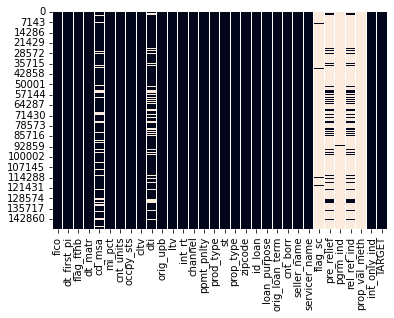

In [ ]:
# identify and visualize missing values
print(df_train.isnull().sum(axis=0))
sns.heatmap(df_train.isnull(), cbar=False);

In [ ]:
# creating new category for NANs for categorical/boolean features
## pgrm_ind
df_train['pgrm_ind'].fillna('N', inplace = True)
## pre_relief
df_train['pre_relief'].fillna('N', inplace = True)
## flag_sc
df_train['flag_sc'].fillna('N', inplace = True)
## flag_fthb 
df_train['flag_fthb'].fillna('N', inplace = True)
## rel_ref_ind
df_train['rel_ref_ind'].fillna('N', inplace = True)
## prop_val_meth
### first change data type from int to object, otherwise .fillna does not work
df_train.prop_val_meth = df_train.prop_val_meth.astype('object')
df_train['prop_val_meth'].fillna('N', inplace = True)

In [ ]:
# handeling numeric missing values
missing_numerics =['fico', 'cltv', 'ltv', 'dti', 'cd_msa']

for var in missing_numerics:
  print(f"missings in {var}:")
  print(df_train[var].isnull().sum(axis=0))

# dti by far biggest number 
# msa will be dropped anyway 

missings in fico:
10
missings in cltv:
4
missings in ltv:
4
missings in dti:
26153
missings in cd_msa:
20971


In [ ]:
# multiple missings in rows?
print(df_train.isnull().sum(axis=1).head())
df_train.isnull().sum(axis=1).unique()

0    0
1    0
2    0
3    1
4    0
dtype: int64


array([0, 1, 2, 3])

In [ ]:
# drop mssings in ['fico', 'cltv', 'ltv'], because so few missings
df_train = df_train.dropna(subset=['fico', 'cltv', 'ltv'])

#check wether it worked
missing_numerics =['fico', 'cltv', 'ltv']


for var in missing_numerics:
  print(f"missings in {var}:")
  print(df_train[var].isnull().sum(axis=0))


print(df_train.isnull().sum(axis=1).unique())

missings in fico:
0
missings in cltv:
0
missings in ltv:
0
[0 1 2]


Dti = ORIGINAL DEBT-TO-INCOME (DTI) RATIO 
- Disclosure of the debt to income ratio is based on 
  1)  the sum of the borrower's monthly debt payments, including monthly housing expenses that incorporate the mortgage payment the borrower is making at the time of the delivery of the mortgage loan to Freddie Mac, divided by 
  2)  the total monthly income used to underwrite the loan as of the date of the origination of the such loan.
- Ratios greater than 65% are indicated that data is Not Available. 
- All loans in the HARP dataset will be disclosed as Not Available.
- This disclosure is subject to the widely varying standards originators use to verify Borrowers' assets and liabilities and will not be updated.

In [ ]:
print(df_train['rel_ref_ind'].unique())
print(df_train['dti'].unique())

['N' 'Y']
<IntegerArray>
[  36,   26,   37,   21,   10,   31,   28,   33,   20,   44,   41,   23,   27,
   19,   17,   38,   43,   46,   18,   35,   29,   45,   25,   32,   40,   50,
   39,   30,   22, <NA>,   42,   34,   47,   16,   13,   24,   12,   48,   11,
   49,   14,    9,   15,    3,    8,    7,    2,    4,    1,    6,    5]
Length: 51, dtype: Int64


In [ ]:
print("number of dti that need filling")
print(sum(df_train['dti'].isnull()))

print("got HARP")
print(sum(df_train['rel_ref_ind']=="Y") )

print("got HARP and missing dti") # <- reason for missing is HARP
print(sum((df_train['dti'].isnull()) & (df_train['rel_ref_ind']=="Y") ))

print("missing dti with missing harp indicator")
print(sum((df_train['dti'].isnull()) & (df_train['rel_ref_ind'].isnull())))

print("missing dti with harp indicator==N") # <- had >65% dti
sum((df_train['dti'].isnull()) & (df_train['rel_ref_ind']=="N"))

number of dti that need filling
26148
got HARP
26143
got HARP and missing dti
26143
missing dti with missing harp indicator
0
missing dti with harp indicator==N


5

[0 1]
Target values in sub0: [0]
unique values of rel_ref_ind in sub0: ['N' 'Y']
unique values of rel_ref_ind in sub0 after dropping missings in dti: ['N']


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


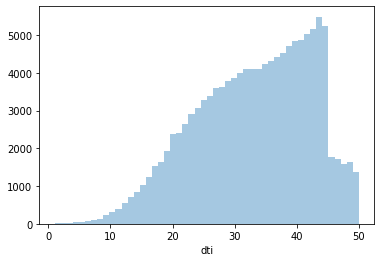

In [ ]:
print(df_train['TARGET'].unique())
data_sub0 = df_train.loc[df_train['TARGET'] == 0]
print(f"Target values in sub0: {data_sub0['TARGET'].unique()}")
print(f"unique values of rel_ref_ind in sub0: \
{data_sub0['rel_ref_ind'].unique()}")

data_sub0 = data_sub0.dropna(subset=['dti'])
print(f"unique values of rel_ref_ind in sub0 after dropping missings in dti: \
{data_sub0['rel_ref_ind'].unique()}")

#Using distplot function, create a graph
sns.distplot( a=data_sub0["dti"], hist=True, kde = False, rug = False)

Target values in sub1: [1]
unique values of rel_ref_ind in sub1: ['Y' 'N']
unique values of rel_ref_ind in sub1 after dropping missings in dti: ['N']


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


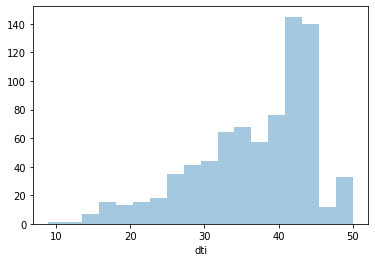

In [ ]:
data_sub1 = df_train.loc[df_train['TARGET'] == 1]
print(f"Target values in sub1: {data_sub1['TARGET'].unique()}")
print(f"unique values of rel_ref_ind in sub1: \
{data_sub1['rel_ref_ind'].unique()}")

data_sub1 = data_sub1.dropna(subset=['dti'])
print(f"unique values of rel_ref_ind in sub1 after dropping missings in dti: \
{data_sub1['rel_ref_ind'].unique()}")

sns.distplot( a=data_sub1["dti"], hist=True, kde = False, rug = False)

['N' 'Y']
['N']
[0]


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


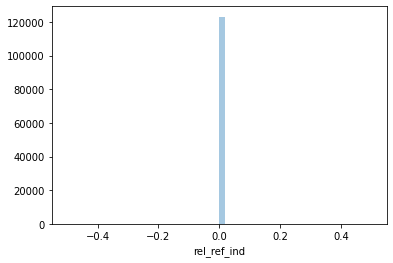

In [ ]:
# recode rel_ref_ind
print(df_train['rel_ref_ind'].unique())
print(data_sub0['rel_ref_ind'].unique())

a_dict = {"Y":1, "N":0}

data_sub0 = data_sub0.replace(dict(rel_ref_ind=a_dict))
print(data_sub0['rel_ref_ind'].unique())

# hist of rel_ref_ind if TARGET==0
sns.distplot( a=data_sub0["rel_ref_ind"], hist=True, kde = False, rug = False)

['N']


`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).


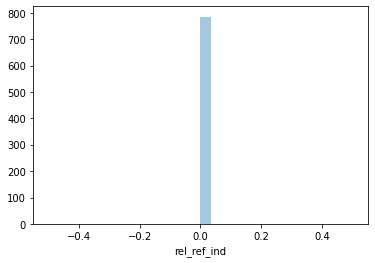

In [ ]:
# recode again
print(data_sub1['rel_ref_ind'].unique())
data_sub1 = data_sub1.replace(dict(rel_ref_ind=a_dict))

# hist of rel_ref_ind if TARGET==1
sns.distplot( a=data_sub1["rel_ref_ind"], hist=True, kde = False, rug = False)

In [ ]:
# correlation between dti and target 
print(df_train[['TARGET', 'dti']].corr())

          TARGET       dti
TARGET  1.000000  0.030039
dti     0.030039  1.000000


In [ ]:
# impute missing dti with cut-off (=65)
df_train['dti'].head()
df_train['dti'].fillna(65, inplace = True) 
print(df_train.isnull().sum(axis=0))

fico                  0
dt_first_pi           0
flag_fthb             0
dt_matr               0
cd_msa            20966
mi_pct                0
cnt_units             0
occpy_sts             0
cltv                  0
dti                   0
orig_upb              0
ltv                   0
int_rt                0
channel               0
ppmt_pnlty            0
prod_type             0
st                    0
prop_type             0
zipcode               0
id_loan               0
loan_purpose          0
orig_loan_term        0
cnt_borr              0
seller_name           0
servicer_name         0
flag_sc               0
pre_relief            0
pgrm_ind              0
rel_ref_ind           0
prop_val_meth         0
int_only_ind          0
TARGET                0
dtype: int64


### Test Data

In [ ]:
# Recode missings
## To better handle the different kinds of encodings for missing values in 
## the dataset, the missings are all transformed into one uniform encoding as 
## NAN values
print("BEFORE RECODING -------------------------------------------------")
print(df_test.isna().sum(axis=0)) # before to compare later
print("INFO")
df_test.info()

# Determine which values are encoded as missings in each feature
missing_as_9999 = ['fico']
missing_as_999 = ['mi_pct', 'cltv',  'dti', 'ltv']
missing_as_99 = ['cnt_units', 'cnt_borr']
missing_as_9 = ['pgrm_ind', 'prop_val_meth']
missing_as_99_str = ['prop_type']
missing_as_9_str = ['pgrm_ind', 'loan_purpose', 'channel', 
                    'occpy_sts', 'flag_fthb']

# Create lists to iterate through them
missings = [missing_as_9999, missing_as_999, missing_as_99, 
            missing_as_9, missing_as_99_str, missing_as_9_str]
missing_numbers =[9999, 999, 99, 9, "99", "9"]

j = -1 #inititalize counter

# Looping through the different kinds of missings and replace them
for i in missing_numbers:
  j= j+1
  def missings_recode(variable):
    if variable== i:
        return np.nan
    else:
        return variable
  for var in missings[j]:
    print(df_test[var].dtypes)
    desired_type = df_test[var].dtypes # store this datatype
    desired_type = str(desired_type).replace("int64", "Int64") 
    df_test[var] = df_test[var].apply(missings_recode)
    # apply desired type 
    df_test[var] = df_test[var].astype(desired_type)

# check whether everything was recoded accordingly  
print("AFTER RECODING -------------------------------------------------")
print(df_test.isna().sum(axis=0)) 
df_test.info()


BEFORE RECODING -------------------------------------------------
fico                  0
dt_first_pi           0
flag_fthb             0
dt_matr               0
cd_msa             5372
mi_pct                0
cnt_units             0
occpy_sts             0
cltv                  0
dti                   0
orig_upb              0
ltv                   0
int_rt                0
channel               0
ppmt_pnlty            0
prod_type             0
st                    0
prop_type             0
zipcode               0
id_loan               0
loan_purpose          0
orig_loan_term        0
cnt_borr              0
seller_name           0
servicer_name         0
flag_sc           48082
pre_relief        48207
pgrm_ind              0
rel_ref_ind       48207
prop_val_meth         0
int_only_ind          0
dtype: int64
INFO
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50015 entries, 0 to 50014
Data columns (total 31 columns):
 #   Column          Non-Null Count  Dtype  
---  ------       

fico                 10
dt_first_pi           0
flag_fthb             0
dt_matr               0
cd_msa             5372
mi_pct                0
cnt_units             0
occpy_sts             0
cltv                  2
dti                1813
orig_upb              0
ltv                   2
int_rt                0
channel               0
ppmt_pnlty            0
prod_type             0
st                    0
prop_type             0
zipcode               0
id_loan               0
loan_purpose          0
orig_loan_term        0
cnt_borr              0
seller_name           0
servicer_name         0
flag_sc           48082
pre_relief        48207
pgrm_ind          46392
rel_ref_ind       48207
prop_val_meth        40
int_only_ind          0
dtype: int64


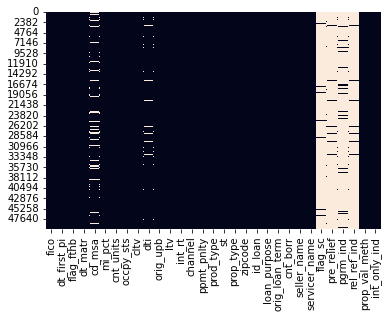

In [ ]:
# identify and visualize missing values
print(df_test.isnull().sum(axis=0))
sns.heatmap(df_test.isnull(), cbar=False);

In [ ]:
# creating new category for categorical/boolean features
## pgrm_ind
df_test['pgrm_ind'].fillna('N', inplace = True)
## pre_relief
df_test['pre_relief'].fillna('N', inplace = True)
## flag_sc
df_test['flag_sc'].fillna('N', inplace = True)
## flag_fthb
df_test['flag_fthb'].fillna('N', inplace = True)
## rel_ref_ind
df_test['rel_ref_ind'].fillna('N', inplace = True)
## prop_val_meth
### first change data type from int to object, otherwise .fillna does not work
df_test.prop_val_meth = df_test.prop_val_meth.astype('object')
df_test['prop_val_meth'].fillna('N', inplace = True)

In [ ]:
# handeling numeric missing values
missing_numerics =['fico', 'cltv', 'ltv', 'dti', 'cd_msa']

for var in missing_numerics:
  print(f"missings in {var}:")
  print(df_test[var].isnull().sum(axis=0))

# dti by far biggest number 
# msa will be dropped anyway 

missings in fico:
10
missings in cltv:
2
missings in ltv:
2
missings in dti:
1813
missings in cd_msa:
5372


In [ ]:
# multiple missings in rows?
print(df_test.isnull().sum(axis=1).head())
df_test.isnull().sum(axis=1).unique()

0    0
1    0
2    0
3    0
4    0
dtype: int64


array([0, 2, 1, 3])

In [ ]:
# replacing missings for numeric data
## fico
df_test['fico'].fillna(df_test['fico'].median(), inplace = True)
## cltv
df_test['cltv'].fillna(df_test['cltv'].median(), inplace = True)
## ltv
df_test['ltv'].fillna(df_test['ltv'].median(), inplace = True)

# check wether it worked
missing_numerics =['fico', 'cltv', 'ltv']


for var in missing_numerics:
  print(f"missings in {var}:")
  print(df_test[var].isnull().sum(axis=0))


print(df_test.isnull().sum(axis=1).unique())

missings in fico:
0
missings in cltv:
0
missings in ltv:
0
[0 2 1]


Dti = ORIGINAL DEBT-TO-INCOME (DTI) RATIO 
- Disclosure of the debt to income ratio is based on 
  1)  the sum of the borrower's monthly debt payments, including monthly housing expenses that incorporate the mortgage payment the borrower is making at the time of the delivery of the mortgage loan to Freddie Mac, divided by 
  2)  the total monthly income used to underwrite the loan as of the date of the origination of the such loan.
- Ratios greater than 65% are indicated that data is Not Available. 
- All loans in the HARP dataset will be disclosed as Not Available.
- This disclosure is subject to the widely varying standards originators use to verify Borrowers' assets and liabilities and will not be updated.

In [ ]:
print(df_test['rel_ref_ind'].unique())
print(df_test['dti'].unique())

['N' 'Y']
<IntegerArray>
[  48,   44,   41,   32,   16, <NA>,   29,   26,   34,   43,   36,   40,   49,
   42,   39,   33,   46,   30,   45,   38,   27,   28,   23,   35,   17,   25,
   24,   13,   37,    6,   50,   21,   47,   31,   18,   20,   15,   19,   22,
   12,   14,    9,   10,    7,   11,    3,    5,    4,    8,    2,    1]
Length: 51, dtype: Int64


In [ ]:
print("number of dti that need filling")
print(sum(df_test['dti'].isnull()))

print("got HARP")
print(sum(df_test['rel_ref_ind']=="Y") )

print("got HARP and missing dti") # <- reason for missing is HARP
print(sum((df_test['dti'].isnull()) & (df_test['rel_ref_ind']=="Y") ))

print("missing dti with missing harp indicator")
print(sum((df_test['dti'].isnull()) & (df_test['rel_ref_ind'].isnull())))

print("missing dti with harp indicator==N") # <- had >65% dti
sum((df_test['dti'].isnull()) & (df_test['rel_ref_ind']=="N"))

number of dti that need filling
1813
got HARP
1808
got HARP and missing dti
1808
missing dti with missing harp indicator
0
missing dti with harp indicator==N


5

In [ ]:
# impute missing dti with cut-off (=65)
df_test['dti'].head()
df_test['dti'].fillna(65, inplace = True) 
print(df_test.isnull().sum(axis=0))

fico                 0
dt_first_pi          0
flag_fthb            0
dt_matr              0
cd_msa            5372
mi_pct               0
cnt_units            0
occpy_sts            0
cltv                 0
dti                  0
orig_upb             0
ltv                  0
int_rt               0
channel              0
ppmt_pnlty           0
prod_type            0
st                   0
prop_type            0
zipcode              0
id_loan              0
loan_purpose         0
orig_loan_term       0
cnt_borr             0
seller_name          0
servicer_name        0
flag_sc              0
pre_relief           0
pgrm_ind             0
rel_ref_ind          0
prop_val_meth        0
int_only_ind         0
dtype: int64


## Adapting Data Formats <a name="Formatting"></a>

After having dealt with missing values, data formats are adapted where needed. As an initial step, the feature ‘id’ is used to index the data. Float variables are expressed in  'mi_pct', 'cltv', 'dti', 'ltv' and 'int_rt' are expressed in percentage terms and hence converted into float. Date variables 'dt_first_pi' and 'dt_matr' are converted into pandas datetime variables and categorical variables are encoded as such. The same applies to Boolean features.

Feature  ‘pre_relief_prog’ originally had the following format: PYYQnXXXXXXX, where ‘P’ is the type of product, ‘YY’ is the year, ‘Qn’ the quarter and the final digits are randomly assigned. We choose to extract the product type only and encode it as a categorical feature. 

We drop features which only take on one unique value as they do not add additional information while increasing dimensionality. In addition, ‘ltv’ is dropped due to its high correlation to ‘cltv’ which we view as logical given the fact that cltv is the Original Combined Loan-to-Value and ltv the Original Loan-to-Value. 


Finally, we drop features ‘zipcode' in addition to ‘cd_msa'. While there are no missing values in ‘zipcode’, its coverage is very low such that each individual value of ‘zipcode’ is only populated by a minor number of observations. In the interest of reduced dimensionality, we thus only use the more granular geographical indicator of state (‘st’). In addition, we aggregate states containing less than 1500 observations (<~1% of observations) into a new category 'Other'. We follow the same approach for the variable 'seller_name' (new category ‘Other sellers’) and ‘servicer_name’ (new category ‘Other servicer’). 


### Training Data 

In [ ]:
# set id_loan as index #########################################################
df_train.set_index(df_train.id_loan, inplace = True)
df_train = df_train.drop('id_loan', axis = 1)

# dealing with numeric features ################################################
## converting 64 to 32
int32_vars = ['fico', 'orig_upb']
for var in int32_vars:
    df_train[var] = df_train[var].astype('int32')
## converting % values to float
float_vars = ['mi_pct', 'cltv', 'dti', 'ltv', 'int_rt', ]
for var in float_vars: 
    df_train[var] = df_train[var].astype('float64')
    df_train[var] = df_train[var]/100.0
    # renaming percentage features to ..._pct
    if (var != 'mi_pct'):
      df_train = df_train.rename(columns = {var : var+'_pct'})
## dropping features based on high correlation
## because ltv and cltv have a really high correlation (>0.95), drop one of them
df_train = df_train.drop('ltv_pct', axis = 1)

# dealing with time features ###################################################
## all time features
time_vars = ['dt_first_pi', 'dt_matr']
## convert to datetime
for var in time_vars:
    df_train[var] = df_train[var].apply(lambda x: pd.to_datetime(str(x), 
                                                                 format='%Y%m'))
    df_train[var].apply(lambda x : (x-datetime.datetime(1970,1,1))\
                        .total_seconds())
    df_train[var] = df_train[var].astype('int64')
## calculate the difference new with unix coding, need to test 
## whether the results are similar or not
df_train.orig_loan_term = df_train.dt_matr - df_train.dt_first_pi
## drop date features because they are just adding noise
## keep the difference as a feature, so the information is not completly lost
df_train = df_train.drop('dt_matr', axis = 1)
df_train = df_train.drop('dt_first_pi', axis = 1)

# dealing with cat features ####################################################
## cnt_units
df_train.cnt_units = df_train.cnt_units.astype('category')
## occpy_sts
df_train.occpy_sts = df_train.occpy_sts.astype('category')
## channel
df_train.channel = df_train.channel.astype('category')
## prop_type
df_train.prop_type = df_train.prop_type.astype('category')
## loan_purpose
df_train.loan_purpose = df_train.loan_purpose.astype('category')
## pgrm_ind
df_train.loc[(df_train['pgrm_ind'] == 'F'), 'pgrm_ind'] = 'Y'
df_train.loc[(df_train['pgrm_ind'] == 'H'), 'pgrm_ind'] = 'Y'
df_train.pgrm_ind = df_train.pgrm_ind.astype('category')
## prop_val_meth
df_train.prop_val_meth = df_train.prop_val_meth.astype('category')
## seller_name
df_train.seller_name = df_train.seller_name.astype('category')
## servicer_name
df_train.servicer_name = df_train.servicer_name.astype('category')
## st
df_train.st = df_train.st.astype('category')

# dealing with other features ##################################################
## pre_relief
## extracting first letter to get product type and create new column with it
df_train['pre_relief_prog'] = df_train['pre_relief'].astype(str).str[0]
df_train['pre_relief_prog'] = df_train.pre_relief_prog.astype('category')
df_train = df_train.drop('pre_relief', axis = 1)

# dealing with geographic features #############################################
## cd_msa
### drop cd_msa feature, not additional information out of it
df_train = df_train.drop('cd_msa', axis = 1)
## zipcode
### drop zipcode because there are too few observations in each category 
## for the model, to gain much information, the overall geographical 
## aspect is representet in states
df_train = df_train.drop('zipcode', axis = 1)

# dealing with boolean features ################################################
## flag_fthb
df_train['flag_fthb'] = df_train['flag_fthb'].map({'Y' : 1, 'N': 0})
df_train['flag_fthb'] = df_train['flag_fthb'].astype('uint8')
## ppmt_pnlty 
df_train['ppmt_pnlty'] = df_train['ppmt_pnlty'].map({'Y' : 1, 'N': 0})
df_train['ppmt_pnlty'] = df_train['ppmt_pnlty'].astype('uint8')
## prod_type 
df_train['prod_type'] = df_train['prod_type'].map({'FRM' : 1, 'ARM': 0})
df_train['prod_type'] = df_train['prod_type'].astype('uint8')
## cnt_borr
df_train.loc[(df_train['cnt_borr'] == 1), 'cnt_borr'] = 0
df_train.loc[(df_train['cnt_borr'] > 1), 'cnt_borr'] = 1
df_train['cnt_borr'] = df_train['cnt_borr'].astype('uint8')
## flag_sc
df_train['flag_sc'] = df_train['flag_sc'].map({'Y' : 1, 'N': 0})
df_train['flag_sc'] = df_train['flag_sc'].astype('uint8')
## rel_ref_ind
df_train['rel_ref_ind'] = df_train['rel_ref_ind'].map({'Y' : 1, 'N': 0})
df_train['rel_ref_ind'] = df_train['rel_ref_ind'].astype('uint8')
## int_only_ind 
df_train['int_only_ind'] = df_train['int_only_ind'].map({'Y' : 1, 'N': 0})
df_train['int_only_ind'] = df_train['int_only_ind'].astype('uint8')
## target
df_train['TARGET'] = df_train['TARGET'].astype('uint8')

# drop freatures with only 1 unique value, no useful information there #########
drop = df_train.loc[:, df_train.nunique() == 1]
drop = drop.columns
print("Variables we drop because there is only one unique value \
in the training set: ", drop)
for col in drop:
    df_train = df_train.drop(labels=col, axis=1)

casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


Variables we drop because there is only one unique value in the training set:  Index(['ppmt_pnlty', 'prod_type', 'prop_val_meth', 'int_only_ind'], dtype='object')


In [ ]:
# Change categories with less observations than 1% of training data to 'others'
# calculate number of observations for each state.
# and replace states with less than 1500 (<~1% of observations) 
# observations by category 'Other'. 
st_count = df_train['st'].value_counts() 
df_train['st'] = np.where(df_train['st']\
                          .isin(st_count[st_count.lt(1500)].index),\
                          'Other',df_train['st'])

# calculate number of observations for each servicers.
# and replace servicers with less than 1500 (<~1% of observations) 
# observations by category 'Other Servicers'. 
servicers_count = df_train['servicer_name'].value_counts() 
df_train['servicer_name'] = np.where(df_train['servicer_name']\
.isin(servicers_count[servicers_count.lt(1500)].index),'Other servicers',\
df_train['servicer_name'])

# calculate number of observations for each sellers.
# and replace sellers with less than (<~1% of observations) 1500 
# observations by category 'Other Sellers'. 
sellers_count = df_train['seller_name'].value_counts() 
df_train['seller_name'] = np.where(df_train['seller_name']\
.isin(sellers_count[sellers_count.lt(1500)].index),'Other sellers',\
df_train['seller_name'])

### Test Data

In [ ]:
# set id_loan as index #########################################################
df_test.set_index(df_test.id_loan, inplace = True)
df_test = df_test.drop('id_loan', axis = 1)

# dealing with numeric features ################################################
## converting 64 to 32
int32_vars = ['fico', 'orig_upb']
for var in int32_vars:
    df_test[var] = df_test[var].astype('int32')
## converting % values to float
float_vars = ['mi_pct', 'cltv', 'dti', 'ltv', 'int_rt', ]
for var in float_vars: 
    df_test[var] = df_test[var].astype('float64')
    df_test[var] = df_test[var]/100.0
    # renaming percentage features to ..._pct
    if (var != 'mi_pct'):
      df_test = df_test.rename(columns = {var : var+'_pct'})
## dropping features based on correlation
## because ltv and cltv have a really high correlation (>0.95) 
## in the train data, drop one of them
df_test = df_test.drop('ltv_pct', axis = 1)

# dealing with time features ###################################################
## determine all time features
time_vars = ['dt_first_pi', 'dt_matr']
for var in time_vars:
    df_test[var] = df_test[var].apply(lambda x: pd.to_datetime(str(x),
                                                               format='%Y%m'))
    df_test[var].apply(lambda x : (x-datetime.datetime(1970,1,1))\
                       .total_seconds())
    df_test[var] = df_test[var].astype('int64')
## calculate the difference new with unix coding, need to test whether 
## the results are similar or not
df_test.orig_loan_term = df_test.dt_matr - df_test.dt_first_pi
## drop time features, no information gain
## keep the difference as a feature, so the information is not completly lost
df_test = df_test.drop('dt_matr', axis = 1)
df_test = df_test.drop('dt_first_pi', axis = 1)

# dealing with cat features ####################################################
## cnt_units
df_test.cnt_units = df_test.cnt_units.astype('category')
## occpy_sts
df_test.occpy_sts = df_test.occpy_sts.astype('category')
## channel
df_test.channel = df_test.channel.astype('category')
## prop_type
df_test.prop_type = df_test.prop_type.astype('category')
## loan_purpose
df_test.loan_purpose = df_test.loan_purpose.astype('category')
## pgrm_ind
df_test.loc[(df_test['pgrm_ind'] == 'F'), 'pgrm_ind'] = 'Y'
df_test.loc[(df_test['pgrm_ind'] == 'H'), 'pgrm_ind'] = 'Y'
df_test.pgrm_ind = df_test.pgrm_ind.astype('category')
## prop_val_meth 
df_test.prop_val_meth = df_test.prop_val_meth.astype('category')
## seller_name
df_test.seller_name = df_test.seller_name.astype('category')
## servicer_name
df_test.servicer_name = df_test.servicer_name.astype('category')
## st
df_test.st = df_test.st.astype('category')

# dealing with other features ##################################################
## pre_relief
## extracting first letter to get product type and create new column with it
df_test['pre_relief_prog'] = df_test['pre_relief'].astype(str).str[0]
df_test['pre_relief_prog'] = df_test.pre_relief_prog.astype('category')
df_test = df_test.drop('pre_relief', axis = 1)

# dealing with geographic features #############################################
## cd_msa
## drop cd_msa feature, not additional information out of it
df_test = df_test.drop('cd_msa', axis = 1)
## zipcode
### drop zipcode because there are too few observations in each category 
### for the model to gain much information, the overall geographical aspect 
### is representet in states
df_test = df_test.drop('zipcode', axis = 1)

# dealing with boolean features ################################################
## flag_fthb
df_test['flag_fthb'] = df_test['flag_fthb'].map({'Y' : 1, 'N': 0})
df_test['flag_fthb'] = df_test['flag_fthb'].astype('uint8')
## ppmt_pnlty 
df_test['ppmt_pnlty'] = df_test['ppmt_pnlty'].map({'Y' : 1, 'N': 0})
df_test['ppmt_pnlty'] = df_test['ppmt_pnlty'].astype('uint8')
## prod_type 
df_test['prod_type'] = df_test['prod_type'].map({'FRM' : 1, 'ARM': 0})
df_test['prod_type'] = df_test['prod_type'].astype('uint8')
## cnt_borr
df_test.loc[(df_test['cnt_borr'] == 1), 'cnt_borr'] = 0
df_test.loc[(df_test['cnt_borr'] > 1), 'cnt_borr'] = 1
df_test['cnt_borr'] = df_test['cnt_borr'].astype('uint8')
## flag_sc
df_test['flag_sc'] = df_test['flag_sc'].map({'Y' : 1, 'N': 0})
df_test['flag_sc'] = df_test['flag_sc'].astype('uint8')
## rel_ref_ind
df_test['rel_ref_ind'] = df_test['rel_ref_ind'].map({'Y' : 1, 'N': 0})
df_test['rel_ref_ind'] = df_test['rel_ref_ind'].astype('uint8')
## int_only_ind 
df_test['int_only_ind'] = df_test['int_only_ind'].map({'Y' : 1, 'N': 0})
df_test['int_only_ind'] = df_test['int_only_ind'].astype('uint8')

# drop same features as for training data because they just had 1 unique 
# value in training data
print("Variables we drop because there is only one unique value \
in the training set: ", drop)
for col in drop:
    df_test = df_test.drop(labels=col, axis=1)

casting datetime64[ns] values to int64 with .astype(...) is deprecated and will raise in a future version. Use .view(...) instead.


Variables we drop because there is only one unique value in the training set:  Index(['ppmt_pnlty', 'prod_type', 'prop_val_meth', 'int_only_ind'], dtype='object')


## Handling Category Mismatches <a name="Mismatches"></a>

To ensure that the algorithm is capable of handling unknown categories we compare test and training data and encode any new categories as “Other”. This is the most reasonable modeling choice in our opinion as the algorithm is unable to interpret new categories in a sensible way if it has not been trained on them. 


Afterwards, we dummy encode all categorical variables. 


In [ ]:
# Identify shared unique values for the specific categorical features
# seller_name ##################################################################
print("Seller_name")
# Common Categories in seller_name
seller_name_train = df_train['seller_name'].unique()
seller_name_test = df_test['seller_name'].unique()
# Difference in the number of unique values in the 2 datasets
print("Number of unique seller_names in train data: ",len(seller_name_train))
print("Number of unique seller_names in test data: ", len(seller_name_test)) 
# Create empty list to save the common values
Common_Sellers = []
# Loop through both lists and find shared values
for i in seller_name_train:
  for j in seller_name_test:
    if(isinstance(i, str) and i == j):
      Common_Sellers.append(i)
# Print shared unique values and number of unique values
print("Shared Unique seller_names: ",Common_Sellers)
print("Number of shared unique seller_names: ", len(Common_Sellers))

# servicer_name ################################################################
print("Servicer_name")
# Common Categories in servicer_name
servicer_name_train = df_train['servicer_name'].unique()
servicer_name_test = df_test['servicer_name'].unique()
# Difference in 2 datasets
print("Number of unique servicer_name in train data: ",len(servicer_name_train))
print("Number of unique servicer_name in test data: ", len(servicer_name_test)) 
# Create empty list to save the common values
Common_Servicer = []
# Loop through both lists and find shared values
for i in servicer_name_train:
  for j in servicer_name_test:
    if(isinstance(i, str) and i == j):
      Common_Servicer.append(i)
# Print shared unique values and number of unique values
print("Shared Unique servicer_name: ", Common_Servicer)
print("Number of shared unique servicer_name: ", len(Common_Servicer))

# st ###########################################################################
print("ST")
# Common Categories in st
st_train = df_train['st'].unique()
st_test = df_test['st'].unique()
# Number of unique values in the two datasets
print("Number of unique states in train data: ", len(st_train))
print("Number of unique states in test data: ", len(st_test)) 
# Create empty list to save the common values
Common_st = []
# Loop through both lists and find shared values
for i in st_train:
  for j in st_test:
    if(isinstance(i, str) and i == j):
      Common_st.append(i)
# Print shared unique values and number of unique values
print("Shared Unique states: ", Common_st)
print("Number of shared unique states: ", len(Common_st))

Seller_name
Number of unique seller_names in train data:  19
Number of unique seller_names in test data:  27
Shared Unique seller_names:  ['QUICKEN LOANS INC.', 'Other sellers', 'BRANCH BANKING & TRUST COMPANY', 'U.S. BANK N.A.', 'WELLS FARGO BANK, N.A.', 'LOANDEPOT.COM, LLC', 'JPMORGAN CHASE BANK, N.A.', 'SUNTRUST MORTGAGE, INC.', 'FRANKLIN AMERICAN MORTGAGE COMPANY', 'BANK OF AMERICA, N.A.', 'CITIMORTGAGE, INC.', 'STEARNS LENDING, LLC', 'NATIONSTAR MORTGAGE LLC', 'FLAGSTAR BANK, FSB', 'CALIBER HOME LOANS, INC.', 'GUARANTEED RATE, INC.']
Number of shared unique seller_names:  16
Servicer_name
Number of unique servicer_name in train data:  17
Number of unique servicer_name in test data:  29
Shared Unique servicer_name:  ['Other servicers', 'FREEDOM MORTGAGE CORPORATION', 'TRUIST BANK', 'U.S. BANK N.A.', 'WELLS FARGO BANK, N.A.', 'QUICKEN LOANS INC.', 'JPMORGAN CHASE BANK, NATIONAL ASSOCIATION', 'LAKEVIEW LOAN SERVICING, LLC', 'NEW RESIDENTIAL MORTGAGE LLC', 'PNC BANK, NA', 'BANK OF AME

In [ ]:
# Change all categories not shared to 'Others'
# seller_name ##################################################################
print("Number of Transformations for the feature seller_name")
## Change values of non-shared categories to Other sellers 
## Train data
counter = 0
for seller in df_train['seller_name'] : 
  if(seller not in Common_Sellers):
    counter +=1
    df_train['seller_name'] = df_train['seller_name']\
                              .replace([seller], 'Other sellers')
## Print number of transformations
print("Training transformation:" , counter)
## Test data
counter = 0
for seller in df_test['seller_name'] : 
  if(seller not in Common_Sellers):
    counter +=1
    df_test['seller_name'] = df_test['seller_name']\
                             .replace([seller], 'Other sellers')
## Print number of transformations
print("Test transformation:" , counter)

# servicer_name ################################################################
print("Number of Transformations for the feature servicer_name")
## Change values of non-shared categories to Other servicers
## Train data
counter = 0
for servicer in df_train['servicer_name'] : 
  if(servicer not in Common_Servicer):
    counter +=1
    df_train['servicer_name'] = df_train['servicer_name']\
                                .replace([servicer], 'Other servicers')
## Print number of transformations
print("Training transformation:" , counter)
## Test data
counter = 0
for servicer in df_test['servicer_name'] : 
  if(servicer not in Common_Servicer):
    counter +=1
    df_test['servicer_name'] = df_test['servicer_name']\
                              .replace([servicer], 'Other servicers')
## Print number of transformations
print("Test transformation:" , counter)

# st ###########################################################################
print("Number of Transformations for the feature st")
## Change values of non-shared categories to Other
## Train data
counter = 0
for st in df_train['st'] : 
  if(st not in Common_st):
    counter +=1
    df_train['st'] = df_train['st'].replace([st], 'Other')
## Print number of transformations
print("Training transformation:" , counter)
## Test data
counter = 0
for st in df_test['st'] : 
  if(st not in Common_st):
    counter +=1
    df_test['st'] = df_test['st'].replace([st], 'Other')
## Print number of transformations
print("Test transformation:" , counter)

Number of Transformations for the feature seller_name
Training transformation: 3
Test transformation: 5560
Number of Transformations for the feature servicer_name
Training transformation: 4
Test transformation: 10872
Number of Transformations for the feature st
Training transformation: 14884
Test transformation: 4597


## Dummy Encoding of Categorical Features <a name="Dummies"></a>

In [ ]:
# dummy coding for all categorical columns for training data
dummy = ['cnt_units', 'occpy_sts', 'channel', 'prop_type', 'loan_purpose', 
         'pgrm_ind', 'pre_relief_prog', 'seller_name', 'st', 'servicer_name']
df_train = pd.get_dummies(df_train, columns = dummy, drop_first = True)

# dummy coding for all categorical columns for test data
dummy = ['cnt_units', 'occpy_sts', 'channel', 'prop_type', 'loan_purpose', 
         'pgrm_ind', 'pre_relief_prog', 'seller_name', 'st', 'servicer_name']
df_test = pd.get_dummies(df_test, columns = dummy, drop_first = True)

## Summary <a name="Summary1"></a>

In [ ]:
# Summary of Preprocessing Steps 

file_name = 'https://raw.githubusercontent.com/Group2Interpretability/\
APA_Interpretability/main/Input/columns_preprocessing.csv'
Preprocessing_Table = pd.read_csv(file_name,index_col=False)
pd.set_option('display.max_colwidth', None)
Preprocessing_Table = Preprocessing_Table.drop('#', axis =1)
dfStyler = Preprocessing_Table.style.set_properties(**{'text-align': 'left'})\
.hide_index()
display(dfStyler.set_table_styles([dict(selector='th', 
                                        props=[('text-align', 'left')])]))


print("-----------------------------------------------------------------------")
print("Table 3: Summary of Preprocessing Steps")

-----------------------------------------------------------------------
Table 3: Summary of Preprocessing Steps


## Dataset Split and Scaling <a name="Split"></a>

As the final preprocessing steps, the data is split into a target- and a feature-dataset and the numerical features of both datasets are standardized. An important observation is that the data is – as one would expect and as has been mentioned previously – highly imbalanced: Only approximately 0.9% of observations default on their loan. 

In [ ]:
# Split train data into features and target
X_train = df_train.drop(['TARGET'], axis=1) 
y_train = df_train[['TARGET']]

# Scale train data
standard = StandardScaler()
# determine numerical featrues which have to be scaled
numerical_cols = df_train.select_dtypes(include=\
                                        [np.float64,np.int64, np.int32]).columns

# Make copy of dataset and scale it
X_train_scaled = X_train.copy()
X_train_scaled[numerical_cols] = standard.fit_transform(X_train_scaled\
                                                        [numerical_cols])

# Scale test data
# determine numerical featrues which have to be scaled
numerical_cols = df_test.select_dtypes(include=\
                                       [np.float64,np.int64, np.int32]).columns

# Make copy of dataset and scale it
X_test = df_test.copy()
X_test_scaled = df_test.copy()
X_test_scaled[numerical_cols] = standard.transform(X_test_scaled\
                                                       [numerical_cols])

# Results <a name="Results"></a>

## Stage II <a name="StageII"></a>

In [ ]:
# setting seed for reproducable outputs
seed = 5

### Logistic Regression

To build our base model, we fit a logistic regression from the package [sklearn](https://scikit-learn.org/stable/) (David Cournapeau 2022) using the ridge regularization and maximal iterations of 500 on the scaled training data. Afterwards we predict the probability of defaulting for the test data observations. On Kaggle, the simple logit achieves an AUC value of 0.71312 on the public score, which will represent our baseline to beat with the XGBoost model.
To interpret logit, we can look at the coefficients output of the model. The values shown below represent the average impact of a change in the features on the log odds. Only the sign of the coefficients can be directly interpreted. For example, the negative coefficient for the feature ‘fico’ means that for a c.p. higher value of ‘fico’ the probability of defaulting decreases which is consistent with our findings in the Data Analysis part. 


To evaluate the degree of the feature influence, we look at the example of the dummy variable ‘servicer_name_Other_servicers’. If this dummy goes from 0 to 1, the log odds change is equal to 2.648731. To interpret this, we first calculate the odds with $odds = exp(2.648731) = 14.13609$. This means, that having this feature attribution ($‘\text{servicer_name_Other_servicers}’ = 1$), on average and c.p., multiplies the probability of defaulting by 14.13609 compared to people not having this feature attribution ($’\text{servicer_name_Other_servicers}’ = 0$).

In [ ]:
# Fit logistic regression model
logit_tuned = LogisticRegression(fit_intercept=True, 
                                 max_iter=500, 
                                 penalty = 'l2', 
                                 random_state = seed)
logit_tuned.fit(X_train_scaled, y_train.values.ravel())     

# rearrange order of features of test data, otherwise prediction does not work
cols_when_model_builds = logit_tuned.feature_names_in_
X_test_scaled = X_test_scaled[cols_when_model_builds]

# predict prop for scaled test data
predictions_prop_logit = logit_tuned.predict_proba(X_test_scaled)[:, 1]
# create wanted output format to upload to kaggle
final_result_logit = pd.DataFrame({'id_loan': X_test_scaled.index,
                                   'TARGET': predictions_prop_logit})
# create csv
final_result_logit.to_csv('submission_logit.csv', index=False)

In [ ]:
with pd.option_context('display.max_rows', None):
  coefficients = pd.DataFrame(zip(X_test_scaled.columns, 
                                  np.transpose(logit_tuned.coef_.tolist()[0])), 
                              columns=['features', 'coef'])
  display(coefficients)

features      coef
0                                                      fico -0.575718
1                                                 flag_fthb  0.108373
2                                                    mi_pct  0.140078
3                                                  cltv_pct  0.210306
4                                                   dti_pct  0.428599
5                                                  orig_upb -0.065771
6                                                int_rt_pct  0.239278
7                                            orig_loan_term  0.110838
8                                                  cnt_borr -0.818664
9                                                   flag_sc  0.018283
10                                              rel_ref_ind -0.020941
11                                              cnt_units_2 -0.417532
12                                              cnt_units_3 -0.647562
13                                              cnt_units_4 -0.072452
14                                              occpy_sts_P -0.024677
15                                              occpy_sts_S -0.156358
16                                                channel_C  0.110683
17                                                channel_R -0.163075
18                                             prop_type_CP  0.217262
19                                             prop_type_MH -0.032544
20                                             prop_type_PU  0.260105
21                                             prop_type_SF  0.354199
22                                           loan_purpose_N -0.310896
23                                           loan_purpose_P -0.570328
24                                               pgrm_ind_Y  0.750346
25                                        pre_relief_prog_F -0.129186
26                                        pre_relief_prog_N  0.051269
27               seller_name_BRANCH BANKING & TRUST COMPANY -1.471682
28                     seller_name_CALIBER HOME LOANS, INC.  0.135019
29                           seller_name_CITIMORTGAGE, INC. -0.914296
30                           seller_name_FLAGSTAR BANK, FSB -0.936513
31           seller_name_FRANKLIN AMERICAN MORTGAGE COMPANY -1.557307
32                        seller_name_GUARANTEED RATE, INC. -1.062020
33                    seller_name_JPMORGAN CHASE BANK, N.A. -0.974412
34                           seller_name_LOANDEPOT.COM, LLC -1.143579
35                      seller_name_NATIONSTAR MORTGAGE LLC -0.811019
36                                seller_name_Other sellers -1.449026
37                           seller_name_QUICKEN LOANS INC. -1.548005
38                         seller_name_STEARNS LENDING, LLC -0.587617
39                      seller_name_SUNTRUST MORTGAGE, INC. -1.520261
40                               seller_name_U.S. BANK N.A.  1.493363
41                       seller_name_WELLS FARGO BANK, N.A.  1.357865
42                                                    st_AZ -0.228960
43                                                    st_CA -0.500678
44                                                    st_CO -0.600718
45                                                    st_CT  0.088731
46                                                    st_FL  0.481450
47                                                    st_GA -0.036790
48                                                    st_IL -0.147373
49                                                    st_IN -0.270770
50                                                    st_KY  0.006386
51                                                    st_MA  0.119735
52                                                    st_MD  0.145042
53                                                    st_MI -0.527370
54                                                    st_MN -0.342316
55                                                    st_MO -0.127068
56                                                    st_NC -

In [ ]:
odds_servicer_name_Other = np.exp(coefficients[coefficients.features == \
                                'servicer_name_Other servicers'].coef.values[0])
odds_servicer_name_Other

14.136094054935588

### XGBoost

As a more advanced technique, we choose [XGBoost]( https://github.com/dmlc/xgboost/blob/5d92a7d936fc3fad4c7ecb6031c3c1c7da882a14/doc/python/python_intro.rst) (xgboost developers 2021). Within the practical application of our project, in addition to the number of base learners and the learning rate, six other hyperparameters were used within the model specification. In order to achieve the maximum possible predictive power within the model specification, a grid search was used as a tuning method in order to achieve the best possible combination of hyperparameter values. The concrete values can be seen within the code. Compared to the previously used logit model, the AUC value could be increased up to 0.73865 on Kaggle. The significance of this increase is discussed in the resume. In addition to the performance, however, due to the complexity of the model, a decrease in interpretability could be observed, which is potentially solved and discussed within the next section.(Friedman 2001)

In [ ]:
# Fitting model
## model was tuned by splitting the training data into train and validation
## grid search and cross validation with different parameters was testet
## best model on validation set got now picked to predict the final model with 
## the complete training set
xgb_tuned = xgb.XGBClassifier(
                             colsample_bytree=0.316666666666, 
                             early_stop = 10 , 
                             learning_rate= 0.125, 
                             max_depth=4,
                             n_estimators=125, 
                             use_label_encoder=False, 
                             eval_metric = 'logloss',
                             random_state = seed)
xgb_tuned.fit(X_train_scaled, y_train.values.ravel())

# rearrange order of features, otherwise the prediction does not work
cols_when_model_builds = xgb_tuned.get_booster().feature_names
X_train_scaled = X_train_scaled[cols_when_model_builds]
X_train = X_train[cols_when_model_builds]
X_test_scaled = X_test_scaled[cols_when_model_builds]
X_test = X_test[cols_when_model_builds]

# predict prob for XGBoost
predictions_prop_xgb = xgb_tuned.predict_proba(X_test_scaled)[:, 1]
# create wanted output format to upload to kaggle
final_result_xgb = pd.DataFrame({'id_loan': X_test_scaled.index,
                                 'TARGET': predictions_prop_xgb})
# create csv
final_result_xgb.to_csv('submission_gxb.csv', index=False)

[07:20:06] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.




## Stage III <a name="StageIII"></a>

In [ ]:
# defining interesting observations to see interpretable outputs
# interesting here are pretty high probability
# Chose row/ observation and extract values
## id = 97993, f_xgb(x) = 0,000073524774
test_point_low = X_test_scaled.index.get_loc(97993)
observation_low = X_test_scaled.iloc[test_point_low,:]
## id = 5563, f_xgb(x) = 0,08390787
test_point_middle = X_test_scaled.index.get_loc(5563)
observation_middle = X_test_scaled.iloc[test_point_middle,:]
## id = 36483, f_xgb(x) = 0,7579817
test_point_high = X_test_scaled.index.get_loc(36483)
observation_high = X_test_scaled.iloc[test_point_high,:]

# All features to give in parameter specification of local 
# interpretability models
X_var_labels = X_test_scaled.columns.values

### ANCHOR

Within the practical application the [anchor method](https://github.com/SeldonIO/alibi) (Robert Samoilescu 2018) delivered an unsatisfying result. Within the observations made regarding the individuals, it was noticed that the method could not provide an explanation regarding predictions with a probability lower than 0.5. For observations with a prediction value higher than 0.5, the method could provide an explanation, but within the coverage value it featured a value below zero and contained at best a relevant feature count between 10 and 20. Occasionally, anchors were identified that contained the entire feature set. The poor quality of the results can be traced back to the high dimension of the feature set and the extremely high ratio between the defaulting and non-defaulting observations (99.1 : 0.9).  This is confirmed by the formal definition of the probabilistic parameter given above in the formal anchor definition. 

In [ ]:
# define prediction function we want to interpret
pred_fun = xgb_tuned.predict_proba 

# Build explanation model
#explainer = AnchorTabular(pred_fun, X_train_scaled.columns, seed=seed)
explainer = AnchorTabular(pred_fun, feature_names=X_var_labels, seed=seed)
explainer.fit(X_train_scaled.to_numpy())

AnchorTabular(meta={
  'name': 'AnchorTabular',
  'type': ['blackbox'],
  'explanations': ['local'],
  'params': {'disc_perc': (25, 50, 75), 'seed': 5},
  'version': '0.7.0'}
)

In [ ]:
# Print prediction the anchor method would make
class_names=['0','1']
print('Prediction for the observation with high probability: ', \
      class_names[explainer.predictor(observation_high.to_numpy()\
                                      .reshape(1, -1))[0]])
# Explain local observation
explanation = explainer.explain(observation_high.to_numpy(), 
                                threshold=0.9, max_anchor_size = None)
# Print the output
print('Anchor Rules: %s' % (' AND '.join(explanation.anchor)))
print('Precision: %.2f' % explanation.precision)
print('Coverage: %.2f' % explanation.coverage)

Prediction for the observation with high probability:  1
Anchor Rules: seller_name_WELLS FARGO BANK, N.A. > 0.00 AND st_FL > 0.00 AND fico <= -0.64 AND servicer_name_Other servicers > 0.00 AND seller_name_Other sellers <= 0.00 AND -0.90 < orig_loan_term <= 0.62 AND rel_ref_ind <= 0.00 AND seller_name_JPMORGAN CHASE BANK, N.A. <= 0.00 AND cltv_pct > -0.48 AND dti_pct > -0.13 AND int_rt_pct > -0.58 AND orig_upb > 0.59 AND pre_relief_prog_F <= 0.00 AND servicer_name_WELLS FARGO BANK, N.A. <= 0.00 AND servicer_name_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION <= 0.00 AND servicer_name_TRUIST BANK <= 0.00 AND st_MI <= 0.00 AND channel_R <= 0.00 AND st_CA <= 0.00 AND occpy_sts_S <= 0.00 AND seller_name_FRANKLIN AMERICAN MORTGAGE COMPANY <= 0.00 AND cnt_units_2 <= 0.00 AND st_WA <= 0.00 AND st_IL <= 0.00 AND st_WI <= 0.00 AND st_MO <= 0.00 AND st_CO <= 0.00 AND seller_name_BRANCH BANKING & TRUST COMPANY <= 0.00
Precision: 0.90
Coverage: 0.00


In [ ]:
# print anchor to see all rules needed to make a 0.95 % precision on that 
# this observation is of class 1
explanation.anchor

['seller_name_WELLS FARGO BANK, N.A. > 0.00',
 'st_FL > 0.00',
 'fico <= -0.64',
 'servicer_name_Other servicers > 0.00',
 'seller_name_Other sellers <= 0.00',
 '-0.90 < orig_loan_term <= 0.62',
 'rel_ref_ind <= 0.00',
 'seller_name_JPMORGAN CHASE BANK, N.A. <= 0.00',
 'cltv_pct > -0.48',
 'dti_pct > -0.13',
 'int_rt_pct > -0.58',
 'orig_upb > 0.59',
 'pre_relief_prog_F <= 0.00',
 'servicer_name_WELLS FARGO BANK, N.A. <= 0.00',
 'servicer_name_JPMORGAN CHASE BANK, NATIONAL ASSOCIATION <= 0.00',
 'servicer_name_TRUIST BANK <= 0.00',
 'st_MI <= 0.00',
 'channel_R <= 0.00',
 'st_CA <= 0.00',
 'occpy_sts_S <= 0.00',
 'seller_name_FRANKLIN AMERICAN MORTGAGE COMPANY <= 0.00',
 'cnt_units_2 <= 0.00',
 'st_WA <= 0.00',
 'st_IL <= 0.00',
 'st_WI <= 0.00',
 'st_MO <= 0.00',
 'st_CO <= 0.00',
 'seller_name_BRANCH BANKING & TRUST COMPANY <= 0.00']

### LIME

Furthermore, we apply LIME. In order to investigate potential stability issues in our application, the version of LIME by [Visani et al. (2022)](https://github.com/giorgiovisani/LIME_stability) is used as this implementation includes a function that checks the previously described stability indices: VSI and CSI.  

Below is the LIME result employed on our XGBoost model using the 10 most important features. Accordingly, LIME predicts a value of 76% probability of default for this specific applicant with a predicted value of 75.6% by XGBoost. Clearly, almost the same probability values resulted from LIME and the original model confirms the well-performed loss minimization in LIME. The results presented show the highest contribution by Wells Fargo Bank being the seller of the mortgage with 5%, while the relatively low fico score as a measure of the applicant's creditworthiness comes next with the value of 3% in worsening the applicant's probability of default. On the positive side, the most impactful feature is the fact that the U.S. Bank is not the seller of the mortgage.  


In [ ]:
## Build explanation model
explainer = LimeTabularExplainerOvr(training_data = X_train_scaled.to_numpy(), 
                                    feature_names=X_var_labels, 
                                    class_names=['0','1'], 
                                    verbose=True,
                                    random_state = seed)

## Visualize output
# 10 most important features
k=10 
# define prediction function we want to interpret
pred_fun = xgb_tuned.predict_proba 
exp = explainer.explain_instance(data_row=observation_high.to_numpy(), 
                                 predict_fn=pred_fun, num_features=k)
exp.show_in_notebook(show_table=True)

Intercept 0.05384397044723785
Prediction_local [0.1175635]
Right: 0.7579817


Although the outcome of LIME is somewhat informative to explain the high probability of default for this specific applicant e.g. low creditworthiness being an indicator of the applicant's weak financial standpoint contributing to the high risk of default, the almost negligibly small magnitude of all the 10 variables could be a sign of instability. Following the hints leading to this issue, stability indices for 10, 20, 50 and 100 LIME iterations using the same observation have been checked. The graph below represents the outcome of this experiment. 

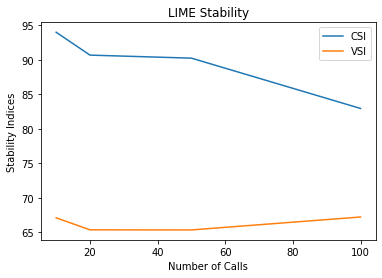

In [ ]:
# Graph for stability indices
n_calls = [10, 20, 50, 100]
CSI =[]
VSI =[]
for call in n_calls:
  stability = explainer.check_stability(data_row=observation_high, \
                                        predict_fn=pred_fun, n_calls = call)
  CSI.append(stability[0]) 
  VSI.append(stability[1])

# Plot Results
plt.plot(n_calls,CSI, label = "CSI")
plt.plot(n_calls,VSI, label = "VSI") 

plt.xlabel('Number of Calls')
plt.ylabel('Stability Indices')
plt.title('LIME Stability')
plt.legend()
plt.show()

Accordingly, relatively steady and high values for CSI show the reliable sign and thus form of contribution (positive/negative) of LIME explanations while lower but steady VSI values require more caution: The variables in our results and consequently our whole explanation is relatively less reliable in terms of the important features describing the probability of default. To be more precise, the magnitude and therefore the order of the most important features in explaining the target could fluctuate in different calls of LIME for the same observation which makes the interpretation less reliable. This issue is relevant in our case due high dimensionality of the dataset which could cause problems mentioned in LIME limitations  and thus somewhat explain the not-so-informative LIME results to some extent. The problem becomes even more concerning when we repeat the stability check for the same number of iterations as the value of each index for a certain number of LIME calls fluctuates as well.

### SHAP

Lastly, we use the presented [TreeExplainer](https://github.com/slundberg/shap) (Scott Lundberg 2017). First, we define the explainer function and calculate the SHAP values for the whole test data. As the feature perturbation method, we use the default value “interventional”. To achieve stable results, we use the whole training data as background data. We now inspect the output of three different observations of the test data, one for which XGBoost predicted a high probability of defaulting (f(x) = 0,7579817), the second with a slightly higher probability of defaulting compared to the base value (f(x) = 0,08390787) and one with a lower probability of defaulting (f(x) = 0,000073524774). The base value represents the average model prediction for the training data with E[f(X)] = 0.012. The figure below shows the waterfall plot with the 15 most important features pushing the base value towards the final prediction for the three observations. The different local feature contributions show similar results regarding the most important features. The level of the contribution depends on the specific feature values and feature combinations. The result of SHAP for the most important features are consistent with our intuitive thoughts after the Data Analysis part. For example, a high ‘fico’ score (e.g., 809 for the low probability prediction) influences the base value negatively and therefore decreases the probability of defaulting, while a low ‘fico’ score (e.g., 620 for the high probability prediction) influences the base value positively and therefore increases the probability of defaulting.


 99%|===================| 49733/50015 [02:46<00:00]       

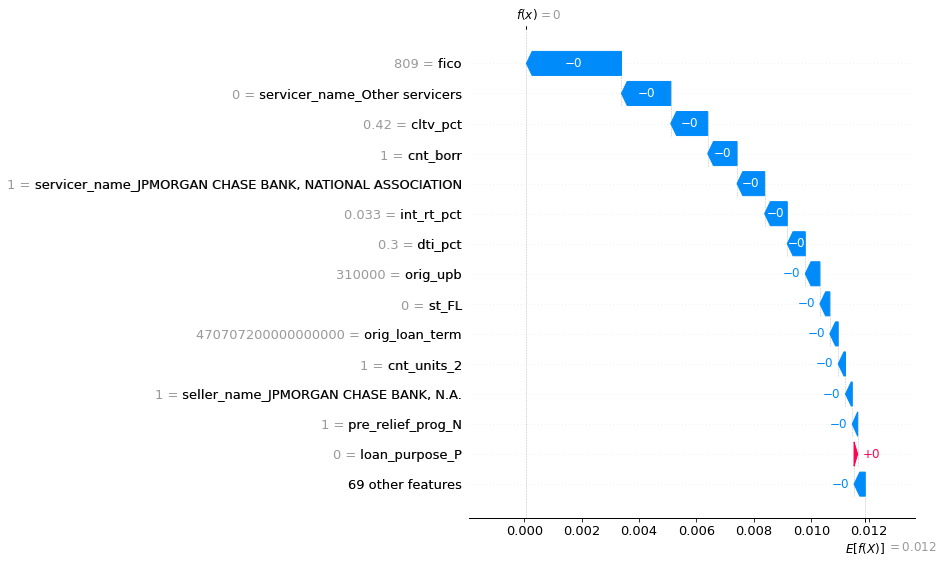

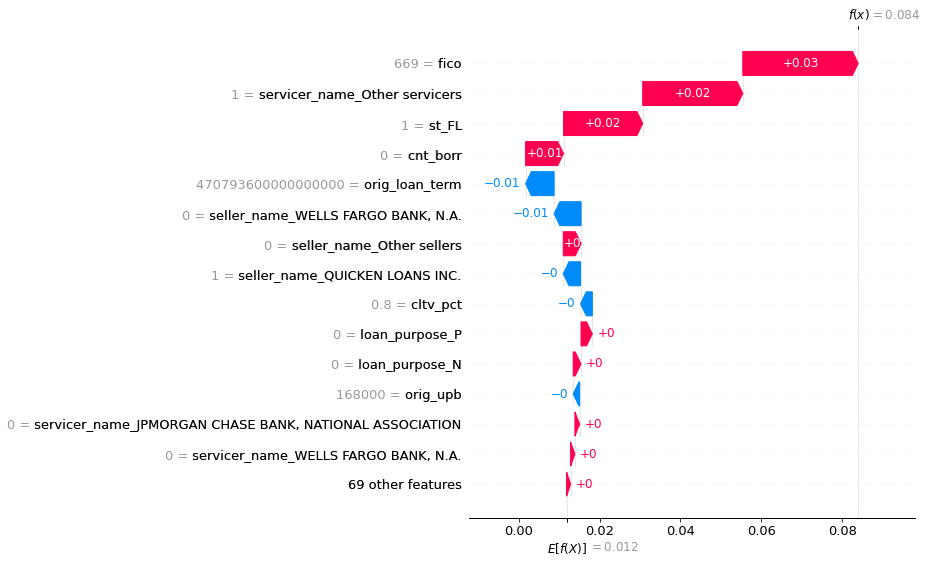

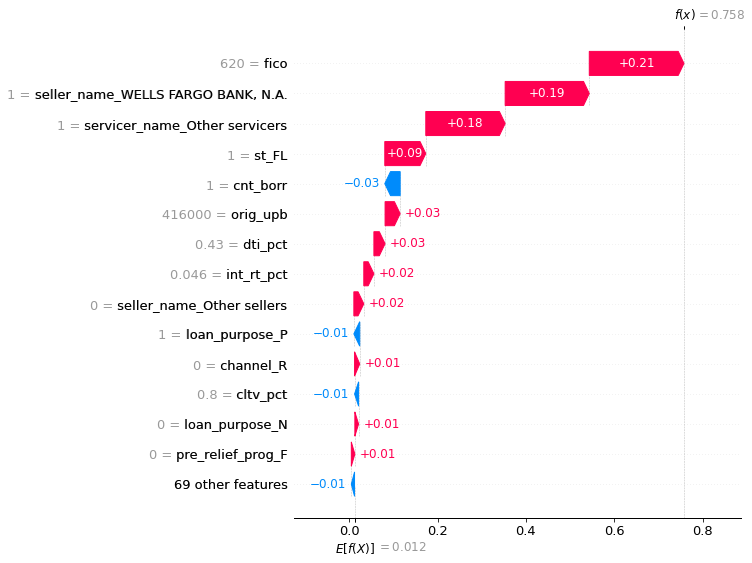

In [ ]:
# Build explanation model
# longer runtime, because the model uses every single observation to create 
# a global explanation as well, to improve interpretability and faithfulness 
# of interpretations of single observations
explainer_xgb = shap.TreeExplainer(xgb_tuned, data=X_train_scaled, 
                                   feature_perturbation='interventional', 
                                   model_output='probability')
shap_values_xgb = explainer_xgb.shap_values(X_test_scaled)

# Generate waterfall plot  
plt_low = shap.plots._waterfall\
.waterfall_legacy(explainer_xgb.expected_value, shap_values_xgb[test_point_low], 
                  features=X_test.values[test_point_low], 
                  feature_names=X_var_labels, max_display=15, show=True)
plt_middle = shap.plots._waterfall\
.waterfall_legacy(explainer_xgb.expected_value, 
                  shap_values_xgb[test_point_middle], 
                  features=X_test.values[test_point_middle], 
                  feature_names=X_var_labels, max_display=15, show=True)
plt_high = shap.plots._waterfall\
.waterfall_legacy(explainer_xgb.expected_value, 
                  shap_values_xgb[test_point_high],
                  features=X_test.values[test_point_high], 
                  feature_names=X_var_labels, max_display=15, show=True)


To gain additional insights into the results, we plot the summary plot, which constructs the global structure and therefore adds a rich summary of the entire model to the individual feature importances. The most important feature over all observations is the ‘fico’ value, followed by the dummy feature ‘servicer_name_Other_servicers’, and the feature ‘cnt_borr’. Comparing the global with the three local plots, we can see many similarities in the global feature importance and the feature importance for these three observations.

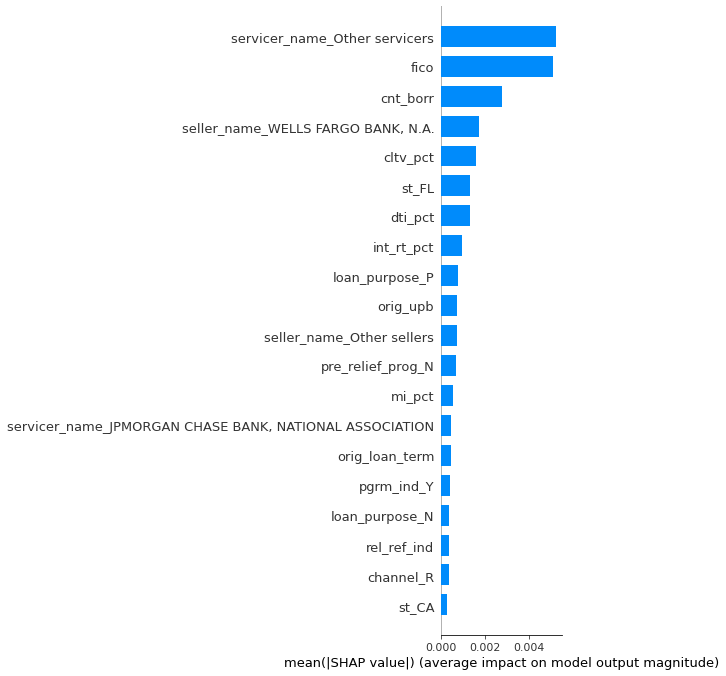

In [ ]:
# Generate summary bar plot to see global feature importance built with many 
# local ones
shap.summary_plot(shap_values_xgb, X_test_scaled,plot_type="bar" , show=True)


**Stability of SHAP**
To eliminate computing complexity, the SHAP package in python includes various explainers for different ML models. For many of those, like the TreeExplainer when using the feature perturbation “interventional” (default value for this function), background data is required and serves as a prior expectation towards the instances to be explained. The official SHAP documentation suggests 100 to 1000 randomly drawn samples from the training data as an adequate background dataset, while other studies employ different sample sizes. The question now is, what is the effect of different background dataset sizes on SHAP TreeExplainer and are the results different when using the feature perturbation approach “tree_path_dependet”, which does not require any background data. Instead, it just follows the trees and use the number of training examples that went down each leaf to represent the background distribution. 

To answer this question, we therefore simulate 100 iterations of SHAP using different sample sizes of the background data (50, 500, 1500, 15000, 150000) to test the stability of SHAP with changing sample sizes. We observe that the order of feature importance fluctuates when using different background data, especially when using small sample sizes. The results suggest that users should take into account how background data affects SHAP results, with improved SHAP stability as the background sample size increases. By using the whole training dataset as background data, the SHAP results are stable. 

The code and further explanations can be found in the Appendix.

## Summary <a name="Summary2"></a>

With respect to the research question and hypotheses stated previously we can thus summarize that we indeed see a trade-off between performance (AUC) and interpretability when comparing Logistic Regression as an intrinsically interpretable method and XGBoost as a black-box model. One might criticize that the AUC improvement appears relatively small. However, this has to be put into perspective, as even a small change in predictive performance may translate into a substantial monetary value for the bank. We expand on this point in the consecutive section. Overall, the results of Stage II confirm hypotheses I and II. 
In Stage III, we are able to construct a model framework applicable within credit risk that achieves a high predictive performance as measure by the AUC whilst maintaining or even improving interpretability; thereby relaxing said tradeoff and confirming hypothesis III. To this end, we use XGBoost as a black-box model and add model-agnostic, local post-hoc methods. Within our framework, SHAP believers the most interpretable and stable results among the three methods considered.  


# A Case for Cost-Sensitive Learning <a name="CostAnalysis"></a>



Even a small increase in predictive performance may transfer into a significant monetary value for financial institutions within credit risk (Emad Azhar Ali et al. 2021; Hayashi 2016; Altinbas and Akkaya 2017). This is due to the fact that the costs of a type I error, i.e. the cost associated with granting a credit to a defaulting customer, differ substantially from the costs of a type II error, i.e. the profit lost by rejecting a non-defaulting customer. As quantifying the exact cost differences requires a large amount of information (such as regulatory capital requirements or exposure at default), the literature makes use of “rules of thumb” regarding appropriates ratios of misclassification costs.(Dumitrescu et al. 2022) However, the magnitudes of the ratios used in the literature vary widely. For example, West (2000) proposes a ratio of 1:5, while others assume as much as 1:20 Kao et al. (2012). For this reason, we quantify the costs once with a ratio of 1:5 (as the lower limit of the expected costs), once with 1:10 (as the middle part of the expected costs) and once with 1:20 (as the upper limit of the expected costs). We make no claim to completeness or precision in this section. Instead, we aim to provide an order of magnitude to illustrate how the increase in the AUC achieved by using XGBoost instead of Logistic Regression translates into costs. 

For this purpose, we split the original training data into training and validation data (70:30) to be able to calculate the corresponding costs of falsely negative predicted observations (FN) and falsely positive predicted observations (FP) and calculate costs corresponding to our predictions using the rules of thumb. Using for example the ratio of 1:5, this means that one FP prediction (giving a loan to a person who will default) costs the bank the same amount as making 5 FN predictions (not giving a loan to a person, who would have not defaulted). 

To determines the threshold for which an observation is predicted as defaulting ($p >= threshold$) or as non-defaulting ($p < threshold$), we follow the approach of Charles Elkan (2001) by calculating the cost-minimal threshold by $ 𝑝(𝑏|𝒙) ≥ 𝜏^∗ =  \frac{𝐶(𝑏,𝐺)}{ 𝐶 (𝑏,𝐺) + 𝐶(𝑔,𝐵)} $ and calculating the different thresholds using the three ratios. We do not use an empirical approach to tune the models using a cost matrix as this would go beyond the scope of this paper. 

To get representative results, we simulate 100 iterations of splitting the original training data into the new training and new validation data (70:30) and build a new Logistic Regression as well as XGBoost with the same parameters as above using the new training data of each iteration. Using these models, we predict the probabilities of the validation observations for each round and calculate the confusion matrix as well as the AUC values for each iteration. 

Afterwards we calculate the average values for AUC, the TP, TN, FP and FN values, visualize them and calculate the costs using the ratios and the corresponding theoretical optimal thresholds. 

The average AUC values do not differ as much in this simulation as above, with Logistic Regression achieving 0.8535 and XGBoost achieving 0.8611.  The average values for the confusion matrix are shown in the graph below. The results do not give consistent results. While the AUC of XGBoost is higher for each iteration and on average than of Logistic Regression, the corresponding costs are not lower for XGBoost for each cost structure. 


These results suggest that when building credit-risk models with imbalanced data, a cost sensitive algorithm should be used rather than only focusing on an improvement of the AUC value. This result should be addressed by future research. In the following section, we point out further limitations and thus potentials for future investigations.

In [ ]:
from sklearn.model_selection import train_test_split, KFold

iterations = 100
standard = StandardScaler()
numerical_cols = X_train.select_dtypes(include=[np.float64,
                                                np.int64, 
                                                np.int32]).columns

xgb_costAnalysis = xgb.XGBClassifier(
                             colsample_bytree=0.316666666666, 
                             early_stop = 10 , 
                             learning_rate= 0.1, 
                             max_depth=4,
                             n_estimators=125, 
                             use_label_encoder=False, 
                             eval_metric = 'logloss',
                             random_state = seed
)

# Fit logistic regression model
logit_costAnalysis = LogisticRegression(fit_intercept=True,max_iter=500, 
                                        penalty = 'l2')


# 1:5 threshold cost matrix for our scenario
cost_matrix_05 = pd.DataFrame({'actual_GOOD(0)': [0, 1], 
                               'actual_BAD(1)': [5, 0]}, 
                              index= ['predicted_GOOD(0)', 'predicted_BAD(1)'])
# 1:10 threshold cost matrix for our scenario
cost_matrix_10 = pd.DataFrame({'actual_GOOD(0)': [0, 1], 
                               'actual_BAD(1)': [10, 0]}, 
                              index= ['predicted_GOOD(0)', 'predicted_BAD(1)'])
# 1:20 threshold cost matrix for our scenario (project-specific)
cost_matrix_20 = pd.DataFrame({'actual_GOOD(0)': [0, 1], 
                               'actual_BAD(1)': [20, 0]}, 
                              index= ['predicted_GOOD(0)', 'predicted_BAD(1)'])

# Bayes optimal threshold 1:5 ratio
threshold_bayes_05 = (cost_matrix_05.iloc[1,0]            # C(b,G)
                   /(cost_matrix_05.iloc[1,0]             # C(b,G)
                     +cost_matrix_05.iloc[0,1])).round(5) # C(g,B)

# Bayes optimal threshold 1:10 ratio
threshold_bayes_10 = (cost_matrix_10.iloc[1,0]            # C(b,G)
                   /(cost_matrix_10.iloc[1,0]             # C(b,G)
                     +cost_matrix_10.iloc[0,1])).round(5) # C(g,B)

# Bayes optimal threshold 1:20 ratio
threshold_bayes_20 = (cost_matrix_20.iloc[1,0]            # C(b,G)
                   /(cost_matrix_20.iloc[1,0]             # C(b,G)
                     +cost_matrix_20.iloc[0,1])).round(5) # C(g,B)


fn_logit_05 = [] 
fn_logit_10 = []
fn_logit_20 = []
fp_logit_05 = []
fp_logit_10 = []
fp_logit_20 = []
fn_xgb_05 = []
fn_xgb_10 = []
fn_xgb_20 = []
fp_xgb_05 = []
fp_xgb_10 = []
fp_xgb_20 = []

tn_logit_05 = [] 
tn_logit_10 = []
tn_logit_20 = []
tp_logit_05 = []
tp_logit_10 = []
tp_logit_20 = []
tn_xgb_05 = []  
tn_xgb_10 = []
tn_xgb_20 = []
tp_xgb_05 = []
tp_xgb_10 = []
tp_xgb_20 = []

cv_auc_logit = []
cv_auc_xgb = []

y = y_train.copy()
y = y.reset_index()

X = X_train.copy()
X = X.reset_index()

X = X.drop('id_loan', axis = 1)
y = y.drop('id_loan', axis = 1)

for i in range(0,iterations):                  
    print('This is iteration number '+ str(i+1))                                    

    X_train_costAnalysis, X_test_costAnalysis, \
    y_train_costAnalysis, y_test_costAnalysis = \
    train_test_split(X, y, test_size=0.3, random_state=i)
  
    # Scale Data
    X_train_scaled_costAnalysis = X_train_costAnalysis.copy()
    X_test_scaled_costAnalysis = X_test_costAnalysis.copy()

    X_train_scaled_costAnalysis[numerical_cols] = \
    standard.fit_transform(X_train_scaled_costAnalysis[numerical_cols])
    X_test_scaled_costAnalysis[numerical_cols] = \
    standard.transform(X_test_scaled_costAnalysis[numerical_cols])
    
    # Fit models
    logit_costAnalysis.fit(X_train_scaled_costAnalysis, 
                           y_train_costAnalysis.values.ravel()) 
    
    
    xgb_costAnalysis.fit(X_train_scaled_costAnalysis, 
                         y_train_costAnalysis.values.ravel())                                                   
    
    # Make probability predictions
    # rearrange order of features, otherwise the prediction does not work
    cols_when_model_builds = xgb_costAnalysis.get_booster().feature_names
    X_test_scaled_costAnalysis = \
    X_test_scaled_costAnalysis[cols_when_model_builds]
    pred_proba_xgb_costAnalysis = \
    xgb_costAnalysis.predict_proba(X_test_scaled_costAnalysis)[:,1]
    
    # rearrange order of features, otherwise the prediction does not work
    cols_when_model_builds = logit_costAnalysis.feature_names_in_
    X_test_scaled_costAnalysis = \
    X_test_scaled_costAnalysis[cols_when_model_builds]
    pred_proba_logit_costAnalysis = \
    logit_costAnalysis.predict_proba(X_test_scaled_costAnalysis)[:,1]
    
    # Make predictions based on bayes threshold
    pred_bayes_xgb_05 = np.where(pred_proba_xgb_costAnalysis \
                                 >= threshold_bayes_05, 1, 0) 
    pred_bayes_xgb_10 = np.where(pred_proba_xgb_costAnalysis \
                                 >= threshold_bayes_10, 1, 0) 
    pred_bayes_xgb_20 = np.where(pred_proba_xgb_costAnalysis \
                                 >= threshold_bayes_20, 1, 0) 
    
    pred_bayes_logit_05 = np.where(pred_proba_logit_costAnalysis \
                                   >= threshold_bayes_05, 1, 0) 
    pred_bayes_logit_10 = np.where(pred_proba_logit_costAnalysis \
                                   >= threshold_bayes_10, 1, 0) 
    pred_bayes_logit_20 = np.where(pred_proba_logit_costAnalysis \
                                   >= threshold_bayes_20, 1, 0) 

    cmat_bayes_xgb_05 = metrics.confusion_matrix(y_test_costAnalysis, 
                                                 pred_bayes_xgb_05)
    cmat_bayes_xgb_10 = metrics.confusion_matrix(y_test_costAnalysis, 
                                                 pred_bayes_xgb_10)
    cmat_bayes_xgb_20 = metrics.confusion_matrix(y_test_costAnalysis, 
                                                 pred_bayes_xgb_20)
    
    cmat_bayes_logit_05 = metrics.confusion_matrix(y_test_costAnalysis, 
                                                   pred_bayes_logit_05)
    cmat_bayes_logit_10 = metrics.confusion_matrix(y_test_costAnalysis, 
                                                   pred_bayes_logit_10)
    cmat_bayes_logit_20 = metrics.confusion_matrix(y_test_costAnalysis, 
                                                   pred_bayes_logit_20)
    
    # Append to specific list to calculate the overall average over all 
    # iterations
    fn_logit_05.append(cmat_bayes_logit_05[0][1])
    fn_logit_10.append(cmat_bayes_logit_10[0][1])
    fn_logit_20.append(cmat_bayes_logit_20[0][1])
    
    fp_logit_05.append(cmat_bayes_logit_05[1][0])
    fp_logit_10.append(cmat_bayes_logit_10[1][0])
    fp_logit_20.append(cmat_bayes_logit_20[1][0])
    
    fn_xgb_05.append(cmat_bayes_xgb_05[0][1])
    fn_xgb_10.append(cmat_bayes_xgb_10[0][1])
    fn_xgb_20.append(cmat_bayes_xgb_20[0][1])
    
    fp_xgb_05.append(cmat_bayes_xgb_05[1][0])
    fp_xgb_10.append(cmat_bayes_xgb_10[1][0])
    fp_xgb_20.append(cmat_bayes_xgb_20[1][0])
    
    tn_logit_05.append(cmat_bayes_logit_05[1][1])
    tn_logit_10.append(cmat_bayes_logit_10[1][1])
    tn_logit_20.append(cmat_bayes_logit_20[1][1])
    
    tp_logit_05.append(cmat_bayes_logit_05[0][0])
    tp_logit_10.append(cmat_bayes_logit_10[0][0])
    tp_logit_20.append(cmat_bayes_logit_20[0][0])
    
    tn_xgb_05.append(cmat_bayes_xgb_05[1][1])
    tn_xgb_10.append(cmat_bayes_xgb_10[1][1])
    tn_xgb_20.append(cmat_bayes_xgb_20[1][1])
    
    tp_xgb_05.append(cmat_bayes_xgb_05[0][0])
    tp_xgb_10.append(cmat_bayes_xgb_10[0][0])
    tp_xgb_20.append(cmat_bayes_xgb_20[0][0])
    
    
    # AUC values
    # Logit
    auc_logit = metrics.roc_auc_score(y_test_costAnalysis, 
                                      pred_proba_logit_costAnalysis)
    cv_auc_logit.append(auc_logit) 
    print('The logit AUC on test set is: {:.4f}'.format(cv_auc_logit[i])) 
    
    # XGB
    auc_xgb = metrics.roc_auc_score(y_test_costAnalysis, 
                                    pred_proba_xgb_costAnalysis)
    cv_auc_xgb.append(auc_xgb) 
    print('The XGB AUC on test set is: {:.4f}'.format(cv_auc_xgb[i]))                                                                  
    print('') 
    

# if it is the final iteration, calculate overall mean of AUC    
print('The final average AUC of XGB is: {:.4f}'.format(sum(cv_auc_logit) \
                                                    / float(len(cv_auc_logit)))) 
print('The final average AUC of Logit is: {:.4f}'.format(sum(cv_auc_xgb) \
                                                      / float(len(cv_auc_xgb))))


This is iteration number 1
[07:52:19] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


The logit AUC on test set is: 0.8576
The XGB AUC on test set is: 0.8642

This is iteration number 2
[07:52:41] WARNING: ../src/learner.cc:627: 
Parameters: { "early_stop" } might not be used.

  This could be a false alarm, with some parameters getting used by language bindings but
  then being mistakenly passed down to XGBoost core, or some parameter actually being used
  but getting flagged wrongly here. Please open an issue if you find any such cases.


The logit AUC on test set is: 0.8481
The XGB AUC on test set is: 0.8577

This is iteration number 3
[07:53:03] WARNING: ../src/learner.cc:627: 
Paramet

In [ ]:
# Calculate the average FN, FP, TP and TN to later on 
# define the confusion matrix
average_fn_logit_05 = sum(fn_logit_05) / float(len(fn_logit_05))
average_fn_logit_10 = sum(fn_logit_10) / float(len(fn_logit_10))
average_fn_logit_20 = sum(fn_logit_20) / float(len(fn_logit_20))
average_fp_logit_05 = sum(fp_logit_05) / float(len(fp_logit_05))
average_fp_logit_10 = sum(fp_logit_10) / float(len(fp_logit_10))
average_fp_logit_20 = sum(fp_logit_20) / float(len(fp_logit_20))

average_fn_xgb_05 = sum(fn_xgb_05) / float(len(fn_xgb_05))
average_fn_xgb_10 = sum(fn_xgb_10) / float(len(fn_xgb_10))
average_fn_xgb_20 = sum(fn_xgb_20) / float(len(fn_xgb_20))
average_fp_xgb_05 = sum(fp_xgb_05) / float(len(fp_xgb_05))
average_fp_xgb_10 = sum(fp_xgb_10) / float(len(fp_xgb_10))
average_fp_xgb_20 = sum(fp_xgb_20) / float(len(fp_xgb_20))

average_tn_logit_05 = sum(tn_logit_05) / float(len(tn_logit_05))
average_tn_logit_10 = sum(tn_logit_10) / float(len(tn_logit_10))
average_tn_logit_20 = sum(tn_logit_20) / float(len(tn_logit_20))
average_tp_logit_05 = sum(tp_logit_05) / float(len(tp_logit_05))
average_tp_logit_10 = sum(tp_logit_10) / float(len(tp_logit_10))
average_tp_logit_20 = sum(tp_logit_20) / float(len(tp_logit_20))

average_tn_xgb_05 = sum(tn_xgb_05) / float(len(tn_xgb_05))
average_tn_xgb_10 = sum(tn_xgb_10) / float(len(tn_xgb_10))
average_tn_xgb_20 = sum(tn_xgb_20) / float(len(tn_xgb_20))
average_tp_xgb_05 = sum(tp_xgb_05) / float(len(tp_xgb_05))
average_tp_xgb_10 = sum(tp_xgb_10) / float(len(tp_xgb_10))
average_tp_xgb_20 = sum(tp_xgb_20) / float(len(tp_xgb_20))

# Create empty bodys for each confusion matrix
cmat_bayes_xgb_05 = np.zeros((2, 2))
cmat_bayes_xgb_10 = np.zeros((2, 2))
cmat_bayes_xgb_20 = np.zeros((2, 2))
cmat_bayes_logit_05 = np.zeros((2, 2))
cmat_bayes_logit_10 = np.zeros((2, 2))
cmat_bayes_logit_20 = np.zeros((2, 2))

# fill the cmats with the average values out of 100 iterations
cmat_bayes_xgb_05[0][0] = average_tp_xgb_05
cmat_bayes_xgb_05[1][0] = average_fp_xgb_05
cmat_bayes_xgb_05[0][1] = average_fn_xgb_05
cmat_bayes_xgb_05[1][1] = average_tn_xgb_05

cmat_bayes_xgb_10[0][0] = average_tp_xgb_10
cmat_bayes_xgb_10[1][0] = average_fp_xgb_10
cmat_bayes_xgb_10[0][1] = average_fn_xgb_10
cmat_bayes_xgb_10[1][1] = average_tn_xgb_10

cmat_bayes_xgb_20[0][0] = average_tp_xgb_20
cmat_bayes_xgb_20[1][0] = average_fp_xgb_20
cmat_bayes_xgb_20[0][1] = average_fn_xgb_20
cmat_bayes_xgb_20[1][1] = average_tn_xgb_20

cmat_bayes_logit_05[0][0] = average_tp_logit_05
cmat_bayes_logit_05[1][0] = average_fp_logit_05
cmat_bayes_logit_05[0][1] = average_fn_logit_05
cmat_bayes_logit_05[1][1] = average_tn_logit_05

cmat_bayes_logit_10[0][0] = average_tp_logit_10
cmat_bayes_logit_10[1][0] = average_fp_logit_10
cmat_bayes_logit_10[0][1] = average_fn_logit_10
cmat_bayes_logit_10[1][1] = average_tn_logit_10

cmat_bayes_logit_20[0][0] = average_tp_logit_20
cmat_bayes_logit_20[1][0] = average_fp_logit_20
cmat_bayes_logit_20[0][1] = average_fn_logit_20
cmat_bayes_logit_20[1][1] = average_tn_logit_20

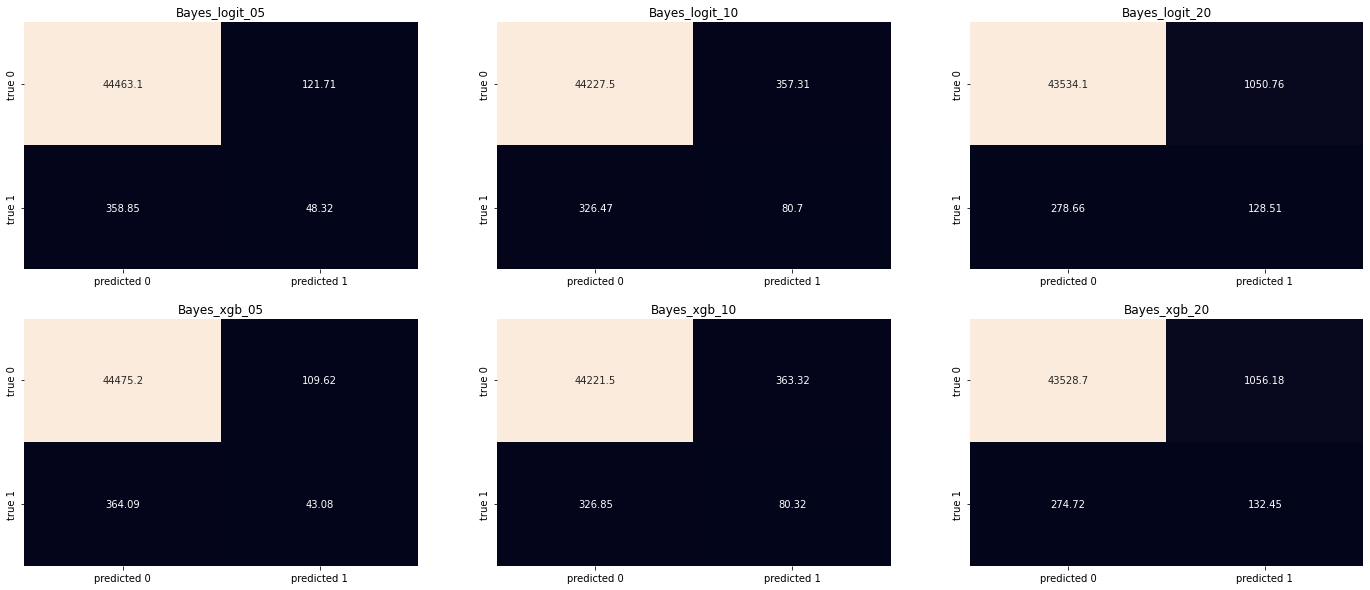

In [ ]:
# Plot Confusion Matrix using Heatmap
plt.rcParams['figure.figsize'] = (24, 10)

import seaborn as sns
fig, ax_lst = plt.subplots(2,3)
cmat_list = [cmat_bayes_logit_05, cmat_bayes_logit_10, cmat_bayes_logit_20, 
             cmat_bayes_xgb_05, cmat_bayes_xgb_10, cmat_bayes_xgb_20]
csm_types = ["Bayes_logit_05", "Bayes_logit_10", "Bayes_logit_20", 
             "Bayes_xgb_05", "Bayes_xgb_10", "Bayes_xgb_20"] 

for i, j, ax in zip(cmat_list, csm_types, ax_lst.flat):

    # Plot heatmap
    ax.set_title(j)
    sns.heatmap(i, ax=ax, annot=True, fmt='g', cbar=False, 
                xticklabels=['predicted 0', 'predicted 1'], 
                yticklabels=['true 0', 'true 1'])
    
plt.show()

In [ ]:
print("Logit:")
print("The error cost for the 1:5 bayes cutoff is: {}".\
      format(np.sum(np.sum(cmat_bayes_logit_05*(cost_matrix_05.T)))))
print("The error cost for the 1:10 bayes cutoff is: {}".\
      format(np.sum(np.sum(cmat_bayes_logit_10*(cost_matrix_10.T)))))
print("The error cost for the 1:20 bayes cutoff is: {}".\
      format(np.sum(np.sum(cmat_bayes_logit_20*(cost_matrix_20.T)))))

print("XGBoost:")
print("The error cost for the 1:5 bayes cutoff is: {}".\
      format(np.sum(np.sum(cmat_bayes_xgb_05*(cost_matrix_05.T)))))
print("The error cost for the 1:10 bayes cutoff is: {}".\
      format(np.sum(np.sum(cmat_bayes_xgb_10*(cost_matrix_10.T))))) 
print("The error cost for the 1:20 bayes cutoff is: {}".\
      format(np.sum(np.sum(cmat_bayes_xgb_20*(cost_matrix_20.T)))))

Logit:
The error cost for the 1:5 bayes cutoff is: 1915.96
The error cost for the 1:10 bayes cutoff is: 3622.01
The error cost for the 1:20 bayes cutoff is: 6623.960000000001
XGBoost:
The error cost for the 1:5 bayes cutoff is: 1930.0699999999997
The error cost for the 1:10 bayes cutoff is: 3631.82
The error cost for the 1:20 bayes cutoff is: 6550.580000000001


# Limitations and Future Research <a name="Limitations"></a>

While the credit risk model framework presented above is successful in relaxing the initial performance-interpretability-tradeoff, it still has several limitations which should be addressed by future research: Firstly, the model does not include any macroeconomic and systemic explanatory variables which might be relevant and might help to increase predictive performance (Uddin et al. 2020; Altinbas and Akkaya 2017; Hu et al. 2021; Xia et al. 2020). 
Secondly, the predictive power of credit risk models may be adversely affected by the widely accepted fact that credit applications can actively influence the parameters on the basis of which banks make their predictions in order to appear more creditworthy. For instance, as explained by Lipton (2016), credit seekers may seemingly “improve” their debt ratio by “simply […] requesting periodic increases to credit lines while keeping spending patterns constant”. Providers of credit ratings such as FICO even openly advise credit applicants on how to improve their score.(Lipton 2016)
Moreover, as has been demonstrated above, there is severe concern about model stability. Given the fact that financial intermediaries play a significant role in our financial system, this is particularly worrying. In the case of Freddie Mac, this became painfully clear during the financial crisis of 2007/2008, when Freddie Mac (together with Fanny Mae) was taken under conservatorship by the Federal Housing Finance Agency (Lockhart 9/7/2008) to prevent the institutions from failing after having accumulated losses amounting to $5.2 trillion of home mortgage debt in total.(Frame et al. 2015) 
In addition, the data’s high imbalance and dimensionality is likely to have complicated the analysis and exacerbated stability concerns. This issue, however, is far from a theoretical concern, but should rather be seen as a real-life problem when dealing with credit risk data. Further research should hence focus on finding ways to improve stability, especially in the presence of highly imbalanced and high dimensional data. 
In conclusion, this analysis shows the potential of machine learning in the credit risk domain, but at the same time indicates that the application of these methods in the real world should be evaluated with caution.


# References <a name="References"></a>


💡 Altinbas, Hazar; Akkaya, Goktug Cenk (2017): Improving the performance of statistical learning methods with a combined meta-heuristic for consumer credit risk assessment. In Risk Manag 19 (4), pp. 255–280. DOI: 10.1057/s41283-017-0021-0.


💡 Baesens, Bart; Setiono, Rudy; Mues, Christophe; Vanthienen, Jan (2003): Using Neural Network Rule Extraction and Decision Tables for Credit-Risk Evaluation. In Management Science 49 (3), pp. 312–329. DOI: 10.1287/mnsc.49.3.312.12739.


💡Basel Committee on Banking Supervision (2004): International Convergence of Capital Measurement and Capital Standards. A Revised Framework.


💡Borisov, Vadim; Leemann, Tobias; Seßler, Kathrin; Haug, Johannes; Pawelczyk, Martin; Kasneci, Gjergji (2021): Deep Neural Networks and Tabular Data: A Survey. Available online at http://arxiv.org/pdf/2110.01889v3.


💡 Bureau of Consumer Financial Protection (2011): Equal Credit Opportunity Act (Regulation B), Part 1002. Source: 12 U.S.C. 5512, 5581; 15 U.S.C. 1691b. In : 76 FR 79445.


💡 Bussmann, Niklas; Giudici, Paolo; Marinelli, Dimitri; Papenbrock, Jochen (2019): Explainable AI in Credit Risk Management. In SSRN Journal. DOI: 10.2139/ssrn.3506274.


💡 Bussmann, Niklas; Giudici, Paolo; Marinelli, Dimitri; Papenbrock, Jochen (2021): Explainable Machine Learning in Credit Risk Management. In Comput Econ 57 (1), pp. 203–216. DOI: 10.1007/s10614-020-10042-0.


💡 Charles Elkan (2001): The Foundations of Cost-Sensitive Learning. Available online at https://www.researchgate.net/publication/2365611_The_Foundations_of_Cost-Sensitive_Learning.


💡 Consumer Financial Protection Bureau (2022): CFPB Circular 2022-03. Available online at https://files.consumerfinance.gov/f/documents/cfpb_2022-03_circular_2022-05.pdf, checked on 7/2/2022.


💡 David Cournapeau (2022): scikit-learn. Machine Learning in Python. With assistance of Jérémie du Boisberranger, Joris Van den Bossche,Loïc Estève,Thomas J. Fan, Alexandre Gramfort, Olivier Grisel, Yaroslav Halchenko, Nicolas Hug. scikitlearnofficial. Available online at https://scikit-learn.org/stable/, updated on May 2022.


💡 Davidson, Russell; MacKinnon, James G. (2004): Econometric theory and methods. New York, NY: Oxford Univ. Press.


💡 Demajo, Lara Marie; Vella, Vince; Dingli, Alexiei (2021): An Explanation Framework for Interpretable Credit Scoring. In IJAIA 12 (1), pp. 19–38. DOI: 10.5121/ijaia.2021.12102.


💡 Deutsche Bundesbank; BaFin (2021): Consultation paper: Machine learning in risk models – Characteristics and supervisory priorities.


💡 Deutsche Bundesbank; BaFin (2022): Machine learning in risk models – Characteristics and supervisory priorities.


💡 Dumitrescu, Elena; Hué, Sullivan; Hurlin, Christophe; Tokpavi, Sessi (2022): Machine learning for credit scoring: Improving logistic regression with non-linear decision-tree effects. In European Journal of Operational Research 297 (3), pp. 1178–1192. DOI: 10.1016/j.ejor.2021.06.053.


💡 E. Hoerl, Robert W. Kennard (1970): Ridge Regression: Biased Estimation for Nonorthogonal Problems, Technometrics. Available online at https://doi.org/10.1080/.


💡 Emad Azhar Ali, Syed; Sajjad Hussain Rizvi, Syed; Lai, Fong-Woon; Faizan Ali, Rao; Ali Jan, Ahmad (2021): Predicting Delinquency on Mortgage Loans: An Exhaustive Parametric Comparison of Machine Learning Techniques. In Int J Ind Eng Manag Volume 12 (Issue 1), pp. 1–13. DOI: 10.24867/IJIEM-2021-1-272.


💡 European Commission (2022): Data protection in the EU. Available online at https://ec.europa.eu/info/law/law-topic/data-protection/data-protection-eu_en, updated on 6/7/2022, checked on 6/21/2022.


💡 European Parliament and the Council (2016): REGULATION (EU) 2016/ 679 - on the protection of natural persons with regard to the processing of personal data and on the free movement of such data, and repealing Directive 95/ 46/ EC (General Data Protection Regulation).


💡 European Union (2012): Charter of Fundamental Rights of the European Union, revised C 326/02. Available online at https://eur-lex.europa.eu/legal-content/EN/TXT/?uri=CELEX:12012P/TXT, checked on 6/21/2022.


💡 Federal Housing Finance Agency (2013): HARP: Your best route to a better mortgage. Available online at https://web.archive.org/web/20130924120848/https://www.harp.gov/, updated on 10/4/2013, checked on 7/13/2022.


💡 Federal Housing Finance Agency (2022): About Fannie Mae & Freddie Mac | Federal Housing Finance Agency. Available online at https://www.fhfa.gov/about-fannie-mae-freddie-mac, updated on 7/3/2022, checked on 7/3/2022.


💡 Frame, W. Scott; Fuster, Andreas; Tracy, Joseph; Vickery, James (2015): The Rescue of Fannie Mae and Freddie Mac. In Journal of Economic Perspectives 29 (2), pp. 25–52. DOI: 10.1257/jep.29.2.25.


💡 Freddie Mac (2021): Single Family Loan-Level Dataset. Available online at https://www.freddiemac.com/research/datasets/sf-loanlevel-dataset, updated on 7/2/2022, checked on 7/3/2022.


💡 Freddie Mac (2022a): About Freddie Mac. Available online at https://www.freddiemac.com/about, updated on 7/2/2022, checked on 7/3/2022.


💡 Freddie Mac (2022b): Single Family Loan-Level Dataset Frequently Asked Questions (FAQs).


💡 Freddie Mac (2022c): Single-Family Loan-Level Dataset General User Guide.


💡 Friedman, Jerome H. (2001): Greedy Function Approximation: A Gradient Boosting Machine. 1999 Reitz Lecture. In The Annals of Statistics 29 (5), pp. 1189–1232.


💡 Goodman, Bryce; Flaxman, Seth (2017): European Union regulations on algorithmic decision-making and a "right to explanation". In AIMag 38 (3), pp. 50–57. DOI: 10.1609/aimag.v38i3.2741.


💡 Hall, Patrick; Gill, Navdeep (2019): An Introduction to Machine Learning Interpretability. An Applied Perspective on Fairness, Accountability, Transparency, and Explainable AI. 2nd: O'Reilly Media, Inc. Available online at https://www.oreilly.com/library/view/an-introduction-to/9781098115487/.


💡Hayashi, Yoichi (2016): Application of a rule extraction algorithm family based on the Re-RX algorithm to financial credit risk assessment from a Pareto optimal perspective. In Operations Research Perspectives 3, pp. 32–42. DOI: 10.1016/j.orp.2016.08.001.


💡 Hu, Linwei; Chen, Jie; Vaughan, Joel; Aramideh, Soroush; Yang, Hanyu; Wang, Kelly et al. (2021): Supervised Machine Learning Techniques: An Overview with Applications to Banking. In International Statistical Review 89 (3), pp. 573–604. DOI: 10.1111/insr.12448.


💡 Kao, Ling-Jing; Chiu, Chih-Chou; Chiu, Fon-Yu (2012): A Bayesian latent variable model with classification and regression tree approach for behavior and credit scoring. In Knowledge-Based Systems 36, pp. 245–252. DOI: 10.1016/j.knosys.2012.07.004.


💡 Li, Wei; Ding, Shuai; Wang, Hao; Chen, Yi; Yang, Shanlin (2020): Heterogeneous ensemble learning with feature engineering for default prediction in peer-to-peer lending in China. In World Wide Web 23 (1), pp. 23–45. DOI: 10.1007/s11280-019-00676-y.


💡 Lipton, Zachary C. (2016): The Mythos of Model Interpretability. Available online at http://arxiv.org/pdf/1606.03490v3.


💡 Liu, Wan’an; Fan, Hong; Xia, Min (2022): Multi-grained and multi-layered gradient boosting decision tree for credit scoring. In Appl Intell 52 (5), pp. 5325–5341. DOI: 10.1007/s10489-021-02715-6.


💡 Lockhart, James B. (9/7/2008): Statement of FHFA Director James B. Lockhart. Federal Housing Finance Agency.


💡 Lundberg, Scott; Lee, Su-In (2017): A Unified Approach to Interpreting Model Predictions. Available online at http://arxiv.org/pdf/1705.07874v2.


💡 Lundberg, Scott M.; Erion, Gabriel; Chen, Hugh; DeGrave, Alex; Prutkin, Jordan M.; Nair, Bala et al. (2020): From local explanations to global understanding with explainable AI for trees. In Nature Machine Intelligence (2), pp. 56–67. Available online at https://www.nature.com/articles/s42256-019-0138-9.


💡 Molnar, Christoph (2022): Interpretable Machine Learning. Available online at https://christophm.github.io/interpretable-ml-book/.


💡 Ribeiro, Marco; Singh, Sameer; Guestrin, Carlos (2016): “Why Should I Trust You?”: Explaining the Predictions of Any Classifier. In Proceedings of the 2016 Conference of the North American Chapter of the Association for Computational Linguistics: Demonstrations, pp. 97–101. DOI: 10.18653/v1/N16-3020.


💡 Ribeiro, Marco Tulio; Singh, Sameer; Guestrin, Carlos (2018): Anchors: High Precision Model-Agnostic Explanations. In AAAI.


💡 Robert Samoilescu (2018): Alibi. Available online at https://github.com/SeldonIO/alibi, updated on 7/20/2022.


💡 Scott Lundberg (2017): SHAP (0.41.0). Available online at https://github.com/slundberg/shap, updated on 1/16/2022.


💡 Shapley, L. S. (1953): 17. A Value for n-Person Games. In Harold William Kuhn, Albert William Tucker (Eds.): Contributions to the Theory of Games (AM-28), Volume II: Princeton University Press, pp. 307–318.


💡 Steenackers, A.; Goovaerts, M. J. (1989): A credit scoring model for personal loans. In Insurance: Mathematics and Economics 8 (1), pp. 31–34. DOI: 10.1016/0167-6687(89)90044-9.


💡 Uddin, Mohammad S.; Chi, Guotai; Al Janabi, Mazin A. M.; Habib, Tabassum (2020): Leveraging random forest in micro‐enterprises credit risk modelling for accuracy and interpretability. In Int. J Fin Econ, Article ijfe.2346. DOI: 10.1002/ijfe.2346.


💡 Visani, Giorgio; Bagli, Enrico; Chesani, Federico; Poluzzi, Alessandro; Capuzzo, Davide (2022): Statistical stability indices for LIME: obtaining reliable explanations for Machine Learning models. In Journal of the Operational Research Society 73 (1), pp. 91–101. DOI: 10.1080/01605682.2020.1865846.


💡 West, David (2000): Neural network credit scoring models. In Computers & Operations Research 27 (11-12), pp. 1131–1152. DOI: 10.1016/S0305-0548(99)00149-5.


💡 William H. Greene (2003): Econometric Analysis. 5th Edition: Pearson Education, Inc.


💡 xgboost developers (2021): XGBoost. With assistance of Andrew Ziem, Philip Hyunsu Cho, Jiaming Yuan. Available online at https://xgboost.readthedocs.io/en/stable/python/python_intro.html, updated on 12/16/2021.


💡 Xia, Yufei; He, Lingyun; Li, Yinguo; Fu, Yating; Xu, Yixin (2020): A DYNAMIC CREDIT SCORING MODEL BASED ON SURVIVAL GRADIENT BOOSTING DECISION TREE APPROACH. In Technological and Economic Development of Economy 27 (1), pp. 96–119. DOI: 10.3846/tede.2020.13997.


💡 Young, H. P. (1985): Monotonic solutions of cooperative games. In Int J Game Theory 14 (2), pp. 65–72. DOI: 10.1007/BF01769885.


💡 Yuan, Han; Liu, Mingxuan; Kang, Lican; Miao, Chenkui; Wu, Ying (2022): An empirical study of the effect of background data size on the stability of SHapley Additive exPlanations (SHAP) for deep learning models.


# Appendix <a name="Appendix"></a>

## Stability of SHAP

### Code

❌Disclaimer, the following section has a very long runtime (> 20 hours), therefore it is all commented.
The results of the analysis can be seen in the Resuls section.

In [ ]:
# Additional libraries needed
from __future__ import print_function
import torch
import math
import collections
import statistics

In [ ]:
# # Calculate SHAP values and global variable rankings under each 
# # background dataset
# # Background datasets are named as x repetition sample size y
# # x stands for the simulation times and y means the sample number 
# # in each background dataset
# # In our example, x=100 and y=0, which means 100 background datasets 
# # will be used.
# # In each background dataset, there are 0 samples
# # Create empty lists to save results later
# orderlist0 = []
# shaplist0 = []
# shaplistsum0 = []
# # i here stands for the simulation times: 100
# # The “tree_path_dependent” approach is to just follow the trees and use the 
# # number of training examples that went down each leaf to represent the 
# # background distribution.
# for i in range(1, 101):
#     # Calculate SHAP with tree_path_dependent approach
#     e = shap.TreeExplainer(xgb_tuned, data=None, 
#                            feature_perturbation='tree_path_dependent', 
#                            model_output='raw')
#     shap_values = e.shap_values(X_test_scaled)
#     shaplist0.append(shap_values)
#     # Calculate the SHAP values of all samples in the test dataset
#     # Add the absolute values together to get the feature importance rankings
#     shap_0_sum = np.absolute(shap_values).sum(axis=0)
#     shaplistsum0.append(shap_0_sum)
#     order_0 = np.argsort(-shap_0_sum) + 1
#     orderlist0.append(order_0)
#     print("background dataset "+str(i)+" has been processed")

# np.savetxt('SHAP_sum0.csv', shaplistsum0, delimiter=',')
# np.savetxt('orderlist0.csv', orderlist0, delimiter=',')

In [ ]:
# # Calculate SHAP values and global variable rankings under each 
# # background dataset
# # Background datasets are named as x repetition sample size y
# # x stands for the simulation times and y means the sample number 
# # in each background dataset
# # In our example, x=100 and y=50, which means 100 background datasets 
# # will be used.
# # In each background dataset, there are 50 samples
# # Create empty lists to save results later
# orderlist1 = []
# shaplist1 = []
# shaplistsum1 = []
# # i here stands for the simulation times: 100
# # In this loop, 50 samples from train dataset will be randomly extracted as 
# # the background dataset
# # Based on each background dataset, calculate the SHAP values and global 
# # ranking for following stability evaluation
# for i in range(1, 101):
#     # With a given seed, the sample will always draw the same rows.
#     # If random_state is None or np.random, then a randomly-initialized 
#     # RandomState object is returned.
#     # Select 50 samples from train data randomly as the background data
#     sample = X_train_scaled.sample(n=50, random_state=i)
#     e = shap.TreeExplainer(xgb_tuned, data=sample, 
#                            feature_perturbation='interventional', 
#                            model_output='probability')
#     shap_values = e.shap_values(X_test_scaled)
#     shaplist1.append(shap_values)
#     # Calculate the SHAP values of all samples in the test dataset
#     # Add the absolute values together to get the feature importance rankings
#     shap_1_sum = np.absolute(shap_values).sum(axis=0)
#     shaplistsum1.append(shap_1_sum)
#     order_1 = np.argsort(-shap_1_sum) + 1
#     orderlist1.append(order_1)
#     print("background dataset "+str(i)+" has been processed")
    
# np.savetxt('SHAP_sum1.csv', shaplistsum1, delimiter=',')
# np.savetxt('orderlist1.csv', orderlist1, delimiter=',')

In [ ]:
# # Calculate SHAP values and global variable rankings under each 
# # background dataset
# # Background datasets are named as x repetition sample size y
# # x stands for the simulation times and y means the sample number in each 
# # background dataset
# # In our example, x=100 and y=500, which means 100 background 
# datasets will be used.
# # In each background dataset, there are 500 samples
# # Create empty lists to save results later
# orderlist2 = []
# shaplist2 = []
# shaplistsum2 = []
# # i here stands for the simulation times: 100
# # In this loop, 500 samples from train dataset will be randomly extracted 
# # as the background dataset
# # Based on each background dataset, calculate the SHAP values and global 
# # ranking for following stability evaluation
# for i in range(1, 101):
#     # With a given seed, the sample will always draw the same rows.
#     # If random_state is None or np.random, then a randomly-initialized 
#     # RandomState object is returned.
#     # Select 500 samples from train data randomly as the background data
#     sample = X_train_scaled.sample(n=500, random_state=i)
#     e = shap.TreeExplainer(xgb_tuned, data=sample, 
#                            feature_perturbation='interventional', 
#                            model_output='probability')
#     shap_values = e.shap_values(X_test_scaled)
#     shaplist2.append(shap_values)
#     # Calculate the SHAP values of all samples in the test dataset
#     # Add the absolute values together to get the feature importance rankings
#     shap_2_sum = np.absolute(shap_values).sum(axis=0)
#     shaplistsum2.append(shap_2_sum)
#     order_2 = np.argsort(-shap_2_sum) + 1
#     orderlist2.append(order_2)
#     print("background dataset "+str(i)+" has been processed")

# np.savetxt('SHAP_sum2.csv', shaplistsum2, delimiter=',')
# np.savetxt('orderlist2.csv', orderlist2, delimiter=',')

In [ ]:
# # Calculate SHAP values and global variable rankings under each 
# # background dataset
# # Background datasets are named as x repetition sample size y
# # x stands for the simulation times and y means the sample number in 
# # each background dataset
# # In our example, x=100 and y=1500, which means 100 background 
# # datasets will be used.
# # In each background dataset, there are 1500 samples
# # Create empty lists to save results later
# orderlist3 = []
# shaplist3 = []
# shaplistsum3 = []
# # i here stands for the simulation times: 100
# # In this loop, 1500 samples from train dataset will be randomly extracted 
# # as the background dataset
# # Based on each background dataset, calculate the SHAP values and global 
# # ranking for following stability evaluation
# for i in range(1, 101):
#     # With a given seed, the sample will always draw the same rows.
#     # If random_state is None or np.random, then a randomly-initialized 
#     # RandomState object is returned.
#     # Select 1500 samples from train data randomly as the background data
#     sample = X_train_scaled.sample(n=1500, random_state=i)
#     e = shap.TreeExplainer(xgb_tuned, data=sample, 
#                            feature_perturbation='interventional', 
#                            model_output='probability')
#     shap_values = e.shap_values(X_test_scaled)
#     shaplist3.append(shap_values)

#     # Calculate the SHAP values of all samples in the test dataset
#     # Add the absolute values together to get the feature importance rankings
#     shap_3_sum = np.absolute(shap_values).sum(axis=0)
#     shaplistsum3.append(shap_3_sum)
#     order_3 = np.argsort(-shap_3_sum) + 1
#     orderlist3.append(order_3)
#     print("background dataset "+str(i)+" has been processed")
    
# np.savetxt('SHAP_sum3.csv', shaplistsum3, delimiter=',')
# np.savetxt('orderlist3.csv', orderlist3, delimiter=',')

In [ ]:
# # Calculate SHAP values and global variable rankings under each 
# # background dataset
# # Background datasets are named as x repetition sample size y
# # x stands for the simulation times and y means the sample number in 
# # each background dataset
# # In our example, x=100 and y=15000, which means 100 background 
# # datasets will be used.
# # In each background dataset, there are 15000 samples
# # Create empty lists to save results later
# orderlist4 = []
# shaplist4 = []
# shaplistsum4 = []
# # i here stands for the simulation times: 100
# # In this loop, 15000 samples from train dataset will be randomly 
# # extracted as the background dataset
# # Based on each background dataset, calculate the SHAP values and global 
# # ranking for following stability evaluation
# for i in range(1, 101):
#     # With a given seed, the sample will always draw the same rows.
#     # If random_state is None or np.random, then a randomly-initialized 
#     # RandomState object is returned.
#     # Select 15000 samples from train data randomly as the background data
#     sample = X_train_scaled.sample(n=15000, random_state=i)
#     e = shap.TreeExplainer(xgb_tuned, data=sample, 
#                            feature_perturbation='interventional', 
#                            model_output='probability')
#     shap_values = e.shap_values(X_test_scaled)
#     shaplist4.append(shap_values)
#     # Calculate the SHAP values of all samples in the test dataset
#     # Add the absolute values together to get the feature importance rankings
#     shap_4_sum = np.absolute(shap_values).sum(axis=0)
#     shaplistsum4.append(shap_4_sum)
#     order_4 = np.argsort(-shap_4_sum) + 1
#     orderlist4.append(order_4)
#     print("background dataset "+str(i)+" has been processed")

# np.savetxt('SHAP_sum4.csv', shaplistsum4, delimiter=',')
# np.savetxt('orderlist4.csv', orderlist4, delimiter=',')

In [ ]:
# # Calculate SHAP values and global variable rankings under each 
# # background dataset
# # Background datasets are named as x repetition sample size y
# # x stands for the simulation times and y means the sample number in 
# # each background dataset
# # In our example, x=100 and y=75000, which means 100 background 
# # datasets will be used.
# # In each background dataset, there are 75000 samples
# # Create empty lists to save results later
# orderlist5 = []
# shaplist5 = []
# shaplistsum5 = []
# # i here stands for the simulation times: 100
# # In this loop, 75000 samples from train dataset will be randomly extracted 
# # as the background dataset
# # Based on each background dataset, calculate the SHAP values and global 
# # ranking for following stability evaluation
# for i in range(1, 101):
#     # With a given seed, the sample will always draw the same rows.
#     # If random_state is None or np.random, then a randomly-initialized 
#     # RandomState object is returned.
#     # Select 75000 samples from train data randomly as the background data
#     sample = X_train_scaled.sample(n=75000, random_state=i)
#     e = shap.TreeExplainer(xgb_tuned, data=sample, 
#                            feature_perturbation='interventional', 
#                            model_output='probability')
#     shap_values = e.shap_values(X_test_scaled)
#     shaplist5.append(shap_values)
#     # Calculate the SHAP values of all samples in the test dataset
#     # Add the absolute values together to get the feature importance rankings
#     shap_5_sum = np.absolute(shap_values).sum(axis=0)
#     shaplistsum5.append(shap_5_sum)
#     order_5 = np.argsort(-shap_5_sum) + 1
#     orderlist5.append(order_5)
#     print("background dataset "+str(i)+" has been processed")

# np.savetxt('SHAP_sum5.csv', shaplistsum5, delimiter=',')
# np.savetxt('orderlist5.csv', orderlist5, delimiter=',')

In [ ]:
# # Calculate SHAP values and global variable rankings under each background 
# # dataset
# # Background datasets are named as x repetition sample size y
# # x stands for the simulation times and y means the sample number 
# # in each background dataset
# # In our example, x=100 and y=~150000, which means 100 background 
# # datasets will be used.
# # In each background dataset, there are ~150000 samples
# # Create empty lists to save results afterwards
# orderlist6 = []
# shaplist6 = []
# shaplistsum6 = []
# # i here stands for the simulation times: 100
# # In this loop, the whole training data is used as background dataset 
# # Based on the background dataset, calculate the SHAP values and global ranking 
# # for following stability evaluation
# for i in range(1, 101):
#     # Calculate SHAP with whole training data as background data
#     e = shap.TreeExplainer(xgb_tuned, data=X_train_scaled, 
#                            feature_perturbation='interventional', 
#                            model_output='probability')
#     shap_values = e.shap_values(X_test_scaled)
#     shaplist6.append(shap_values)
#     # Calculate the SHAP values of all samples in the test dataset
#     # Add the absolute values together to get the feature importance rankings
#     shap_6_sum = np.absolute(shap_values).sum(axis=0)
#     shaplistsum6.append(shap_6_sum)
#     order_6 = np.argsort(-shap_6_sum) + 1
#     orderlist6.append(order_6)
#     print("background dataset "+str(i)+" has been processed")

# np.savetxt('SHAP_sum6.csv', shaplistsum6, delimiter=',')
# np.savetxt('orderlist6.csv', orderlist6, delimiter=',')

### Results

The first table is this section shows the global feature importance ranking for 100 simulations using different background data sizes. The rows represent the ranking from the highest global feature importance (Ranking = 1) to the lowest global feature importance (Ranking = 83). The columns represent the different approaches. For each sample size, we simulate 100 random draws from the training data with the same parameters to see whether we get consistent results. The table shows all possible features which got assigned the specific ranking in at least one iteration.

When using no background data and just the tree path dependent approach explained earlier, as well as using the whole training dataset, we get the same ranking for all 100 simulations, so there is no variation in the ranking. 
When using different sample sizes as background data randomly drawn from the training data, we see for the most and the least important features some variation (~ 3 unique values for the rankings 1-5 and rankings 79-83) while we observe much more variation in the middle with many more unique values for each possible ranking position. 

The results suggest that users should take into account how background data affects SHAP results, and therefore test the stability of their used approach before using it to interpret their model.


In [ ]:
# reading orderlist data
file = 'https://raw.githubusercontent.com/Group2Interpretability/\
APA_Interpretability/main/Input/final_data_var.csv'
final_data_var = pd.read_csv(file, sep=',', index_col = 'features')
file = 'https://raw.githubusercontent.com/Group2Interpretability/\
APA_Interpretability/main/Input/final_order.csv'
final_order = pd.read_csv(file, sep=',', index_col='Ranking of \
Feature (from most to least important)')

In [ ]:
# producing the final order table
with pd.option_context('display.max_rows', None, 
                       'display.max_columns', None):
    display(final_order.style.set_properties(**{'text-align': 'left'})\
            .set_table_styles([dict(selector='th', 
                                    props=[('text-align', 'left')])]))
print("-----------------------------------------------------------------------")
print("Table 4: Ranking Variation over 100 SHAP iterations.")

-----------------------------------------------------------------------
Table 4: Ranking Variation over 100 SHAP iterations.


The second table shows the variance in the SHAP values for each feature over the 100 simulations. We observe for lower background sample sizes (m = 50, m = 500) higher variances as for higher background data sizes. In our case, after using more than 1500 observations, the variance does not significally decrease anymore. 

As described above, when using the whole training data as background data, or using the tree path dependent approach with no background data, SHAP TreeExplainer gives stable results for each iteration.

In [ ]:
# producing the final variance table
with pd.option_context('display.max_rows', None, 
                       'display.max_columns', None):
    display(final_data_var.style.format(precision=0, na_rep='Missings', 
                                        thousands=" ",
                formatter={('Variance sum (m=none)'): "{:.3f}",
                           ('Variance sum (m=50)'): "{:.3f}",
                           ('Variance sum (m=500)'): "{:.3f}",
                           ('Variance sum (m=1500)'): "{:.3f}",
                           ('Variance sum (m=15000)'): "{:.3f}",
                           ('Variance sum (m=75000)'): "{:.3f}",
                           ('Variance sum (m=all)'): "{:.3f}"
                          })\
            .set_table_styles([dict(selector='th', 
                                    props=[('text-align', 'right')])])
            )
print("-----------------------------------------------------------------------")
print("Table 5: Variance in SHAP values over 100 iterations.")

-----------------------------------------------------------------------
Table 5: Variance in SHAP values over 100 iterations.
